# **Data Analyis and Prediction Notebook**
*Note: these notebooks were developed on and are meant to be run using Google Collab. We do not guarantee their immediately functionality outside of this environment.*

Use this notebook and the code within it to train various regression models on the Minecraft celestial body dataset either generated using the image processing notebook or provided by default along with this notebook. 

The code in this notebook makes the following assumptions:
1. You have a folder named "CS189" somewhere in your Google Drive, and that you've added a shorcut to this folder to "My Drive."
2. The folder contains the dataset as a csv named "data_df.csv"

In [1]:
# import necessary tools and dependancies

import torch
import warnings
warnings.filterwarnings('ignore')
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

In [2]:
# Install packages for visualization 

!pip install pydotplus
!pip install graphviz

In [3]:
# mount to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# fix a seed for all randomization tasks

seed = 189
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Extract data from CSV file , split data into train test data sets

CSV_PATH = "drive/My Drive/CS189/data_df.csv"

data = pd.read_csv(CSV_PATH)
data = data.sample(frac=1, random_state = seed)
X = data[["tick", "yaw", "pitch"]]
y = data[["sun_X", "sun_Y", "moon_X",	"moon_Y"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(f"Dimensions of train data:\nX: {X_train.shape}, y: {y_train.shape}")
print(f"Dimensions of test data:\nX: {X_test.shape}, y: {y_test.shape}")

Dimensions of train data:
X: (18720, 3), y: (18720, 4)
Dimensions of test data:
X: (4680, 3), y: (4680, 4)


In [6]:
# print the shapes of the unique input in the suns coordinates

print(y_train["sun_X"].unique().shape)
print(y_train["sun_X"].iloc[y_train["sun_X"].to_numpy().nonzero()[0]].shape)
print(y_train["sun_Y"].unique().shape)

(935,)
(2103,)
(640,)


The most basic model that we used to predict the data is the zero predictor. We expected this model to be a reasonable baseline to evaluate our regression models against as our dataset was sparse and thus the model would be somewhat accurate even with its trivial predictions. We print the MSE errors for both the training and testing datasets

In [7]:
# ZERO BASELINE
zero_pred_test = np.zeros(y_test.shape)
zero_pred_train = np.zeros(y_train.shape)

zero_error_train = mse(y_train, zero_pred_train)
zero_error_test = mse(y_test, zero_pred_test)

print("Zero Prediction on Training Set Error: "+str(zero_error_train) )
print("Zero Prediction on Test Set Error: "+str(zero_error_test) )

Zero Prediction on Training Set Error: 40930.19134615385
Zero Prediction on Test Set Error: 42788.03862179487


The next model that we used is the linear regression model. We expected this to perform slightly better and we included residual vs predicted plots for both the training and testing datasets for each of the coordinates for each of the celestial objects. 

Linear Prediction on Training Set Error: 32427.730080373814
Linear Prediction on Test Set Error: 33852.9223287277
Linear Prediction R^2 Training: 0.1399000630578878
Linear Prediction R^2 Test: 0.1401500077545488


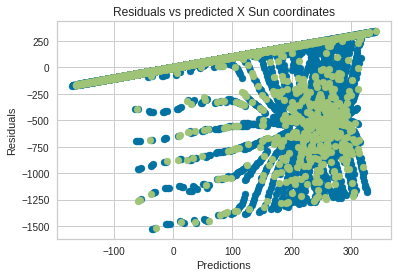

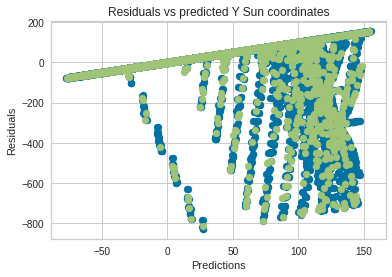

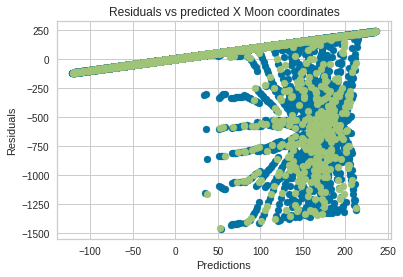

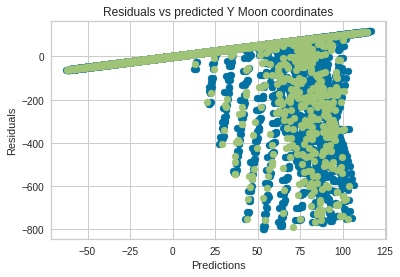

In [8]:
# LINEAR MODEL 
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
lr_error_test = mse(y_test, y_pred_test)
lr_error_train = mse(y_train, y_pred_train)

r_squared_train = lr.score(X_train, y_train)
r_squared_test = lr.score(X_test, y_test)

print("Linear Prediction on Training Set Error: "+str(lr_error_train) )
print("Linear Prediction on Test Set Error: "+str(lr_error_test) )

print("Linear Prediction R^2 Training: "+ str(r_squared_train))
print("Linear Prediction R^2 Test: "+ str(r_squared_test))

# overlaid scatterplots of predicted vs actual coordinates of both training and test data
resid_train = y_pred_train - y_train
resid_test = y_pred_test - y_test
# residual of x coordinates of sun vs predcited both for train and test 
plt.title('Residuals vs predicted X Sun coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.scatter(y_pred_train[:, 0],resid_train.iloc[:, 0])
plt.scatter(y_pred_test[:, 0],resid_test.iloc[:, 0])
plt.show()

# residual of y coordinates of sun vs predcited both for train and test 
plt.title('Residuals vs predicted Y Sun coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.scatter(y_pred_train[:, 1],resid_train.iloc[:, 1])
plt.scatter(y_pred_test[:, 1],resid_test.iloc[:, 1])
plt.show()

# residual of x coordinates of moon vs predcited both for train and test 
plt.title('Residuals vs predicted X Moon coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.scatter(y_pred_train[:, 2],resid_train.iloc[:, 2])
plt.scatter(y_pred_test[:, 2],resid_test.iloc[:, 2])
plt.show()

# residual of y coordinates of moon vs predcited both for train and test
plt.title('Residuals vs predicted Y Moon coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.scatter(y_pred_train[:, 3],resid_train.iloc[:, 3])
plt.scatter(y_pred_test[:, 3],resid_test.iloc[:, 3])
plt.show()

After the linear model, the next approach that we tried is LASSO regression with polynomial features. We expected this to perform slightly better and we included residual vs. predicted plots for both the training and testing datasets for each of the coordinates for both the sun and moon.

LASSO Prediction on Training Set Error: 29449.289281773978
LASSO Prediction on Test Set Error: 30647.539163587302
LASSO Prediction R^2 Training: 0.1399000630578878
LASSO Prediction R^2 Test: 0.1401500077545488


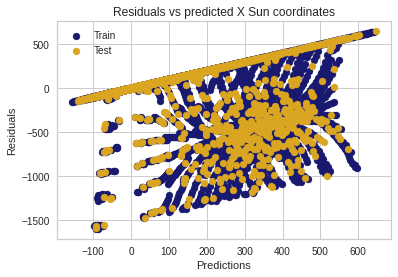

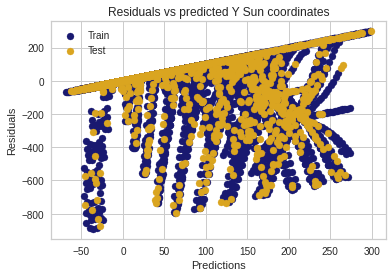

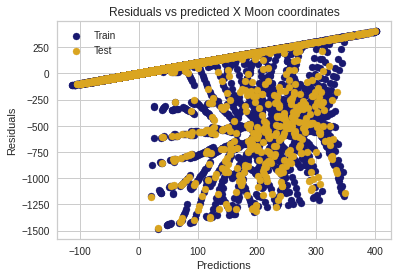

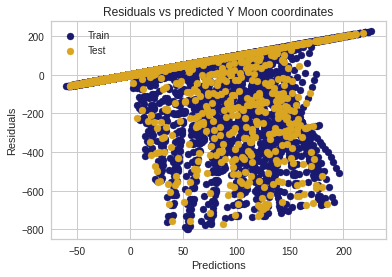

In [9]:
# LASSO REGRESSION WITH POLYNOMIAL FEATURES


pipe = Pipeline([('poly', PolynomialFeatures(2)), ('lasso', Lasso())])
pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

lr_error_test = mse(y_test, y_pred_test)
lr_error_train = mse(y_train, y_pred_train)

r_squared_train = lr.score(X_train, y_train)
r_squared_test = lr.score(X_test, y_test)

print("LASSO Prediction on Training Set Error: "+str(lr_error_train) )
print("LASSO Prediction on Test Set Error: "+str(lr_error_test) )

print("LASSO Prediction R^2 Training: "+ str(r_squared_train))
print("LASSO Prediction R^2 Test: "+ str(r_squared_test))

# overlaid scatterplots of predicted vs actual coordinates of both training and test data
resid_train = y_pred_train - y_train
resid_test = y_pred_test - y_test
# residual of x coordinates of sun vs predcited both for train and test 
plt.title('Residuals vs predicted X Sun coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions') 
plt.scatter(y_pred_train[:, 0],resid_train.iloc[:, 0], label = "Train", c="midnightblue")
plt.scatter(y_pred_test[:, 0],resid_test.iloc[:, 0], label = "Test", c= 'goldenrod')
plt.legend()
plt.show()

# residual of y coordinates of sun vs predcited both for train and test 
plt.title('Residuals vs predicted Y Sun coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions') 
plt.scatter(y_pred_train[:, 1],resid_train.iloc[:, 1], label = "Train", c="midnightblue")
plt.scatter(y_pred_test[:, 1],resid_test.iloc[:, 1], label = "Test", c= 'goldenrod')
plt.legend()
plt.show()

# residual of x coordinates of moon vs predcited both for train and test 
plt.title('Residuals vs predicted X Moon coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions') 
plt.scatter(y_pred_train[:, 2],resid_train.iloc[:, 2], label = "Train", c="midnightblue")
plt.scatter(y_pred_test[:, 2],resid_test.iloc[:, 2], label = "Test", c= 'goldenrod')
plt.legend()
plt.show()

# residual of y coordinates of moon vs predcited both for train and test
plt.title('Residuals vs predicted Y Moon coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions') 
plt.scatter(y_pred_train[:, 3],resid_train.iloc[:, 3], label = "Train", c="midnightblue")
plt.scatter(y_pred_test[:, 3],resid_test.iloc[:, 3], label = "Test", c= 'goldenrod')
plt.legend()
plt.show()

We now move on to a more sophisticated model from which we expect higher accuracy due to the sparse, branched nature of the data. We use the random-forest-based regression, and we perform hyperparameter tuning on max tree depth using 5 fold cross validation. We collect and append all the average errors and proceed to plot the comparison between the cross validation error and regular training error on the same line plot of tree depth vs MSE. Note that the number of trees (100 by default) as well as the K for the K-fold cross validation are hyperparameters. We only tune depth here and keep the other hyperparameters fixed at 100 and 5.

Notice the MSE validation error is significantly lower than our other models at < 5,000.

In [10]:
from sklearn.model_selection import KFold
depth = 30
mses = []
training_error = []
# RANDOM FOREST REGRESSION
# do cross validation here, don't just use test error
for i in range(1,depth):
  kf = KFold(n_splits=5)
  error = 0
  X_train = X_train.reset_index(drop = True)
  y_train = y_train.reset_index(drop = True)
  rf = RandomForestRegressor(max_depth= i , random_state=seed)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_train)
  training_error += [mse(y_train, y_pred)]
  for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    rf = RandomForestRegressor(max_depth= i , random_state=seed)
    rf.fit(X_train_cv, y_train_cv)
    y_pred = rf.predict(X_test_cv)
    error += mse(y_test_cv, y_pred)
  mses.append(error/5)

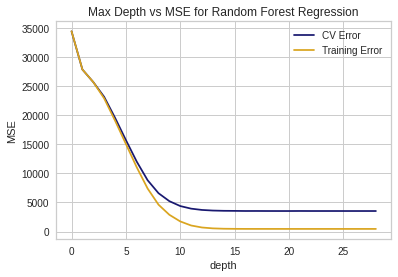

In [11]:
plt.title('Max Depth vs MSE for Random Forest Regression')
plt.ylabel('MSE')
plt.xlabel('depth')
plt.plot(mses, label = "CV Error", c = "midnightblue")
plt.plot(training_error, label = "Training Error", c = "goldenrod")
plt.legend()
plt.show()

In this cell, we again use a random forest approach with a maximum allowed tree depth of 10 but this time we fix it at 10; our hyperparameter is instead the number of trees that we iterate through and for each iteration we do 5 fold cross validation on the training set to randomize the data and to generalize our model's ability. We collect all the average errors and proceed to plot the comparison between the cross validation error and regular training error on the same line plot of number of trees vs MSE. The hyperparameter here is the number of trees, the K is fixed to equal 5 and the max tree depth is fixed to equal 10

In [12]:
from sklearn.model_selection import KFold
depth = 10
mses = []
training_error = []
num_estimators = [1, 10, 100, 200, 500, 1000, 5000]
# RANDOM FOREST REGRESSION
# do cross validation here, don't just use test error
for i in num_estimators:
  kf = KFold(n_splits=5)
  error = 0
  X_train = X_train.reset_index(drop = True)
  y_train = y_train.reset_index(drop = True)
  rf = RandomForestRegressor(n_estimators = i, max_depth= depth , random_state=seed)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_train)
  training_error += [mse(y_train, y_pred)]
  for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    rf = RandomForestRegressor(n_estimators = i, max_depth= depth , random_state=seed)
    rf.fit(X_train_cv, y_train_cv)
    y_pred = rf.predict(X_test_cv)
    error += mse(y_test_cv, y_pred)
  mses.append(error/5)

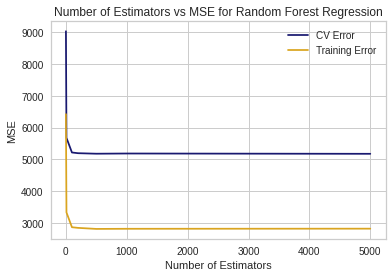

In [13]:
plt.title('Number of Estimators vs MSE for Random Forest Regression')
plt.ylabel('MSE')
plt.xlabel('Number of Estimators')
plt.plot(num_estimators, mses, label = "CV Error", c = "midnightblue")
plt.plot(num_estimators, training_error, label = "Training Error", c = "goldenrod")
plt.legend()
plt.show()

In the cell below, we fix a tree depth of 12 and we fit a random forest model on the training data and we record our predictions for both the training and the testing data, then we calculate the residuals of each. In order to rescale the data, uncomment the 4 lines of code, and edit the last two lines to be the difference of the scaled data sets instead.

In [14]:
# picking a max depth near the elbow , say depth = 15 and plot the absolute difference of each predicted and true test point
rf = RandomForestRegressor(max_depth= 12 , random_state=seed)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# rescaling to get numbers to be close to eachother , then plot predicted vs true values

# scaled_pred_train = (y_pred_train - np.mean(y_pred_train) )/(np.std(y_pred_train))
# scaled_train = (y_train - np.mean(y_train) )/(np.std(y_train))
# scaled_pred_test = (y_pred_test - np.mean(y_pred_test) )/(np.std(y_pred_test))
# scaled_test = (y_test - np.mean(y_test) )/(np.std(y_test))

resid_train = y_pred_train - y_train
resid_test = y_pred_test - y_test

In this cell, the residuals vs the predicted coordinates for both the training set and testing set are plotted for each of the x and y coordinates for each of the celestial objects. The residuals seem to be closer to 0 than the previous plots, suggesting an improvement in the model

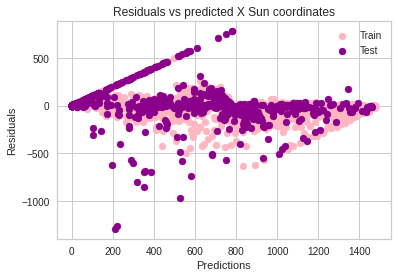

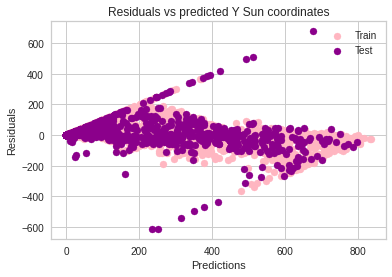

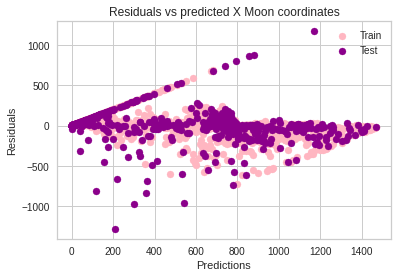

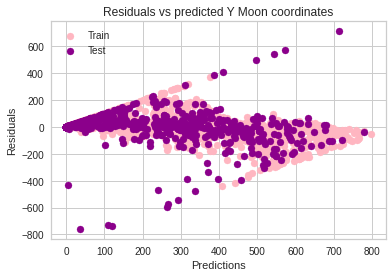

In [15]:
# overlaid scatterplots of predicted vs actual coordinates of both training and test data

# residual of x coordinates of sun vs predcited both for train and test 
plt.title('Residuals vs predicted X Sun coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.scatter(y_pred_train[:, 0],resid_train.iloc[:, 0], label = "Train", c="lightpink")
plt.scatter(y_pred_test[:, 0],resid_test.iloc[:, 0], label = "Test", c= 'darkmagenta')
plt.legend()
plt.show()

# residual of y coordinates of sun vs predcited both for train and test 
plt.title('Residuals vs predicted Y Sun coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.scatter(y_pred_train[:, 1],resid_train.iloc[:, 1], label = "Train", c="lightpink")
plt.scatter(y_pred_test[:, 1],resid_test.iloc[:, 1], label = "Test", c= 'darkmagenta')
plt.legend()
plt.show()

# residual of x coordinates of moon vs predcited both for train and test 
plt.title('Residuals vs predicted X Moon coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.scatter(y_pred_train[:, 2],resid_train.iloc[:, 2], label = "Train", c="lightpink")
plt.scatter(y_pred_test[:, 2],resid_test.iloc[:, 2], label = "Test", c= 'darkmagenta')
plt.legend()
plt.show()

# residual of y coordinates of moon vs predcited both for train and test
plt.title('Residuals vs predicted Y Moon coordinates')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.scatter(y_pred_train[:, 3],resid_train.iloc[:, 3], label = "Train", c="lightpink")
plt.scatter(y_pred_test[:, 3],resid_test.iloc[:, 3], label = "Test", c= 'darkmagenta')
plt.legend()
plt.show()

In the cell below, a random forest model is implemented with 100 trees and a maximum allowed depth of 5. Then a visualization of the decision tree's branches are displayed, showing the relevant values that are cutoff points. In order to expand the visualization, double click on the output. To observe a different result, change the n_estimators argument to a different number of your choice and change the max_depth to a different number and observe the results below.

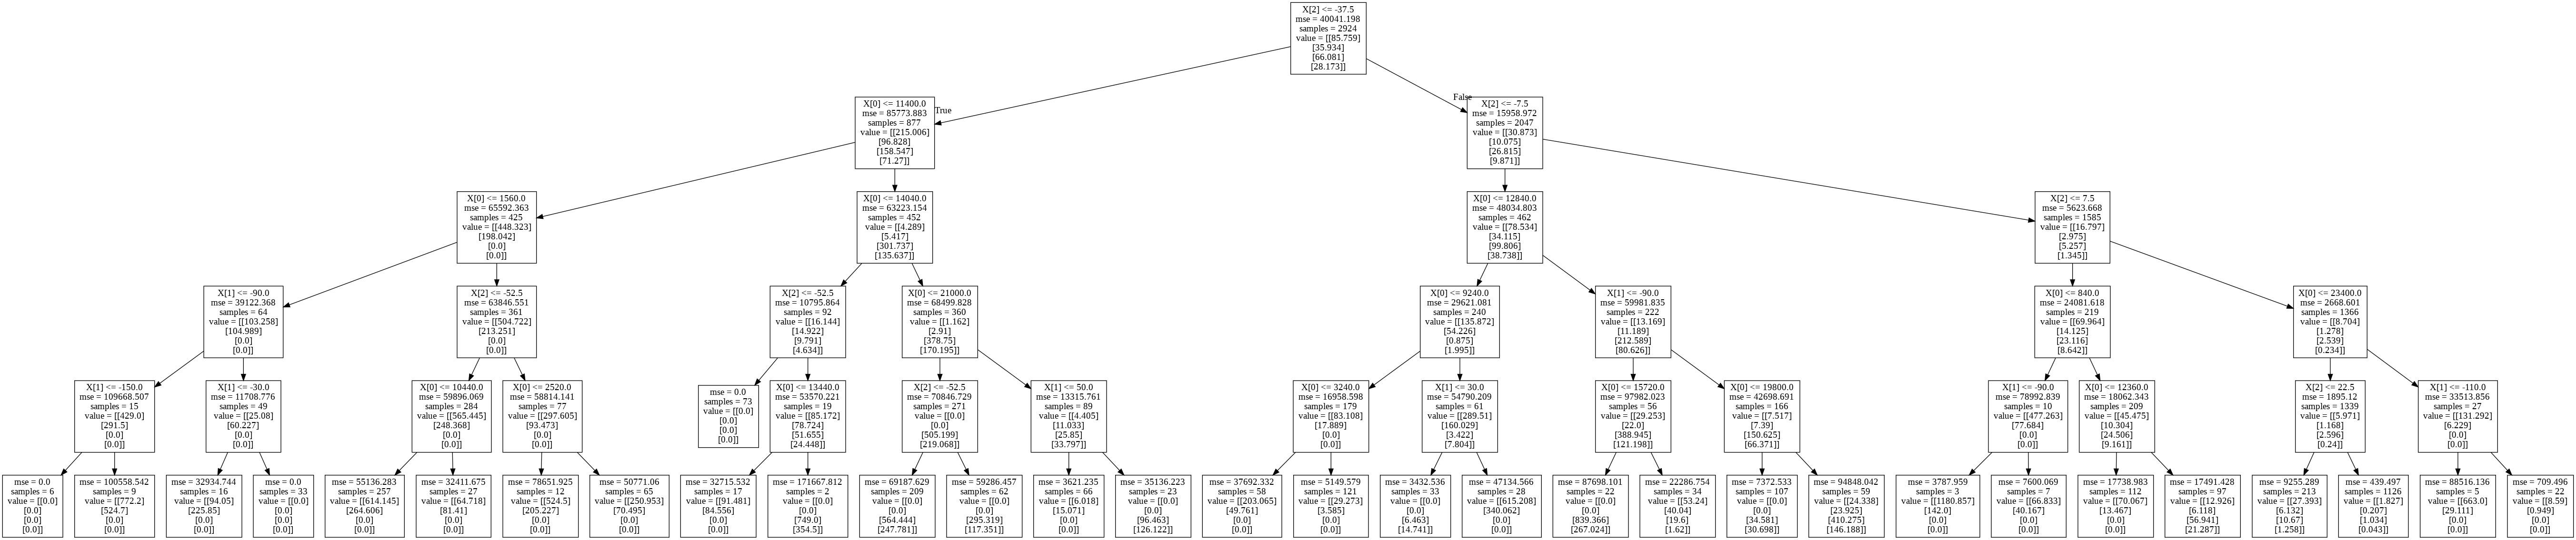

In [16]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

# Credit to https://medium.com/@anthonycarlleston/visualizing-the-decisiontrees-in-randomforestregressor-in-a-pipeline-with-python-f5519f80e3f8

rf = RandomForestRegressor(n_estimators = 100, max_depth = 5 , random_state=seed)
rf.fit(X_test, y_test)
os.environ['PATH'] = os.environ['PATH']+';'+r"\Library\bin\graphviz"
dot_data = StringIO()
export_graphviz(rf.estimators_[0], out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In the cell below, we import some images to prepare for the upcoming cells where we see how our predictions compare against the true centroids on the images themselves.

In [17]:
import cv2
from google.colab.patches import cv2_imshow

import zipfile
import os
image_folder = "drive/My Drive/CS189/screenshot_data.zip"
with zipfile.ZipFile(image_folder) as z:
  z.extractall()
image_folder = "screenshot_data"
cs189_images = os.listdir(image_folder)
num_images = len(os.listdir(image_folder))
print(num_images)

16200


A random forest model with a max tree depth of 12 and 100 estimators (by default) is created and fit. The mean squared error of the test data is displayed. This was one of our "best" configurations and the one we mention in our write-up.

In [31]:
rf = RandomForestRegressor(max_depth= 12 , random_state=seed)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse(y_test, y_pred)

3244.6313950259687

In the cell below, 20 Images with residuals of more than 500 are obtained and the predicted centroids are plotted on the original images with the true centroid locations for the purpose of showing large prediction error. Feel free to play with the parameters and change them up to obtain more or less of these images.

File name is  y140_p-60_t1440.jpg
index0


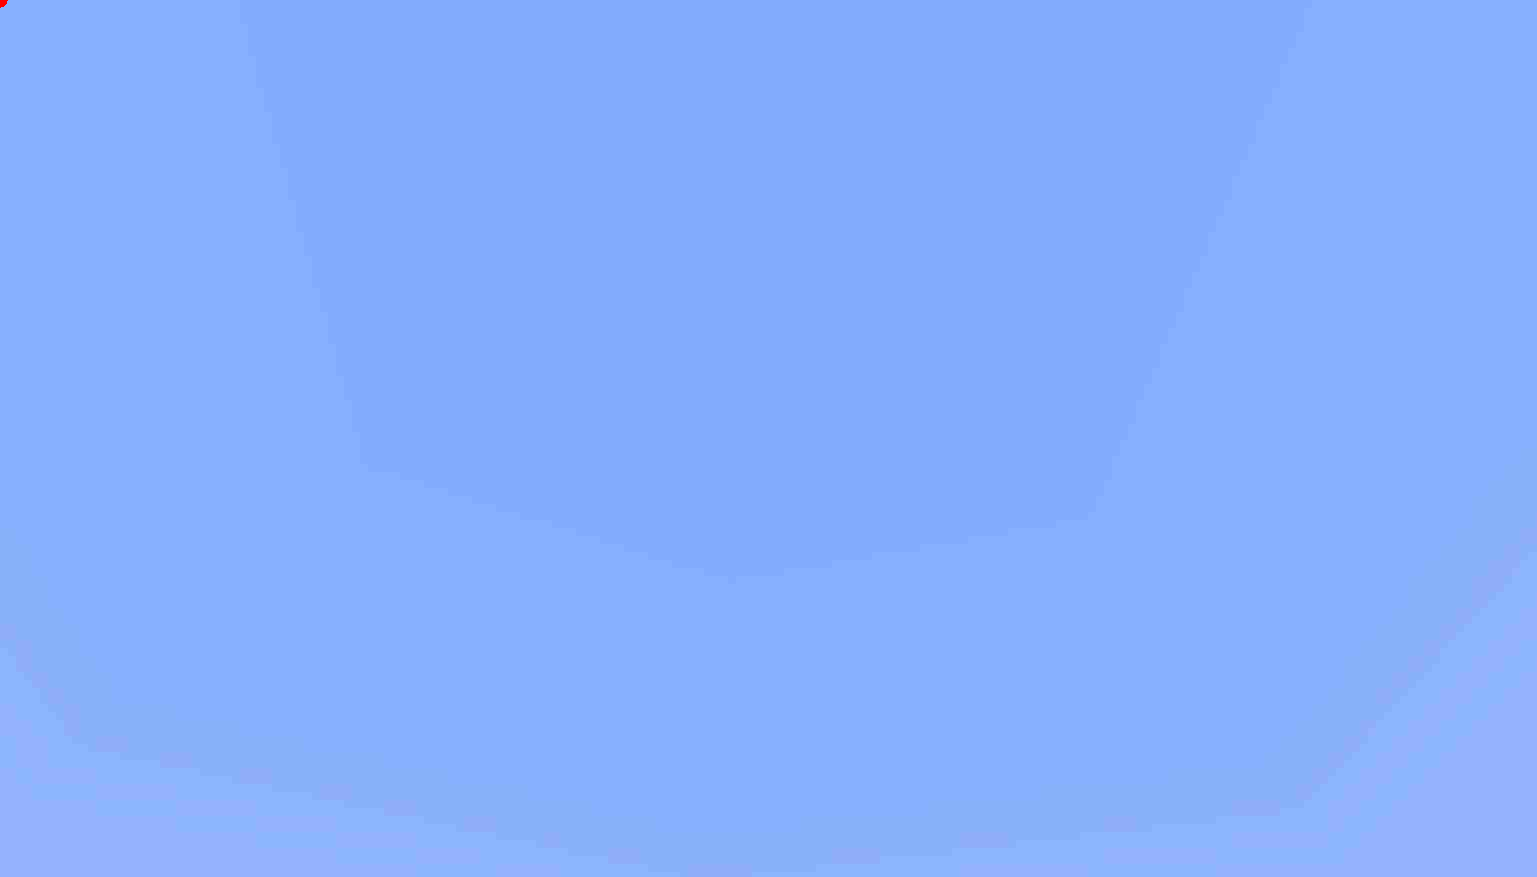

File name is  y-20_p-45_t22560.jpg
index1


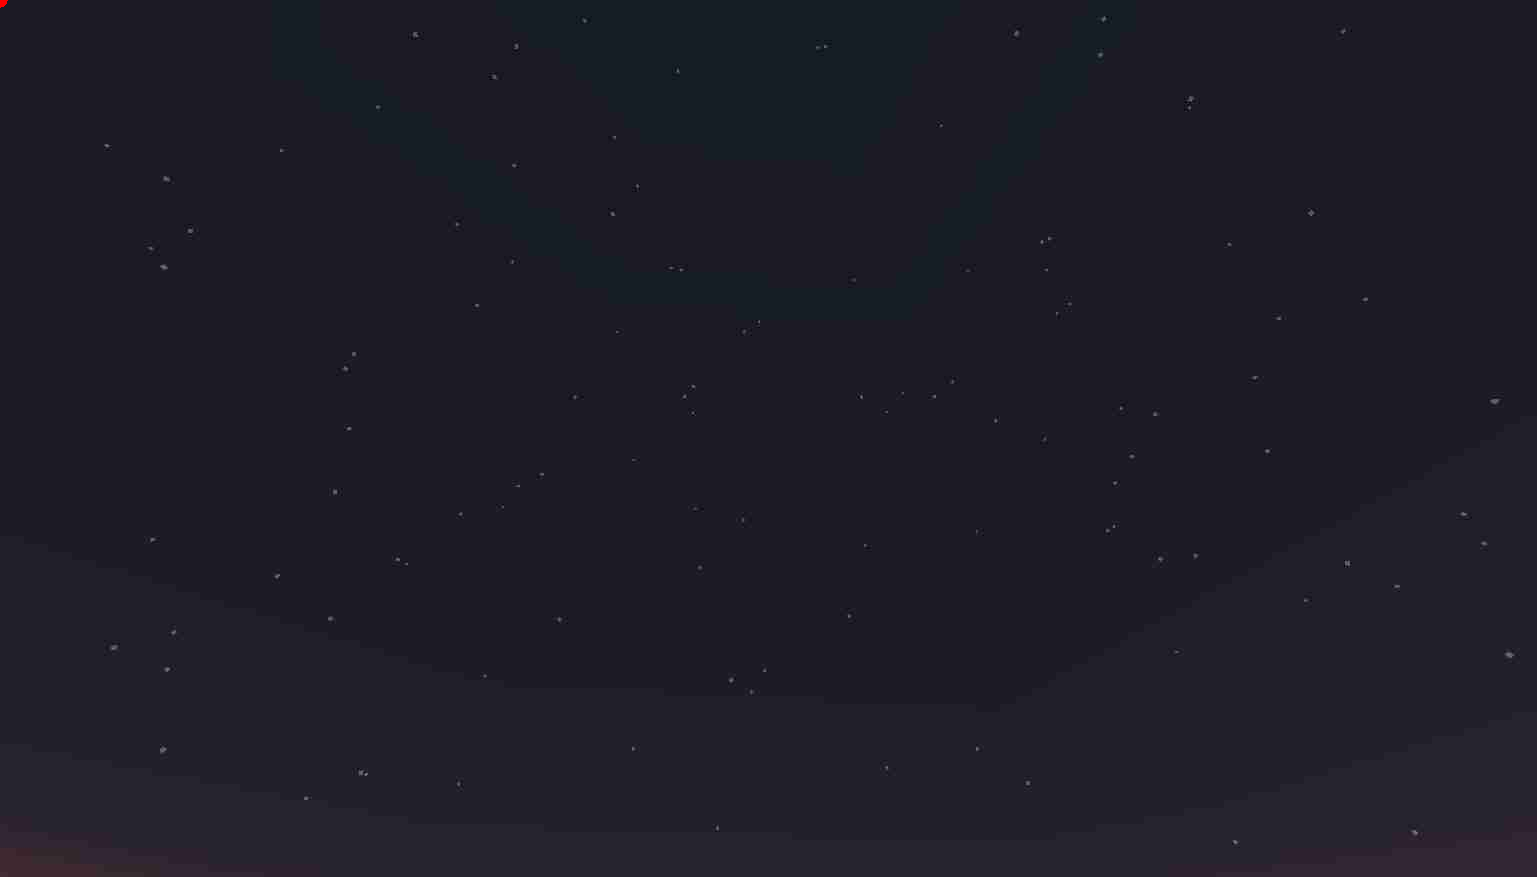

File name is  y160_p30_t6480.jpg
index3


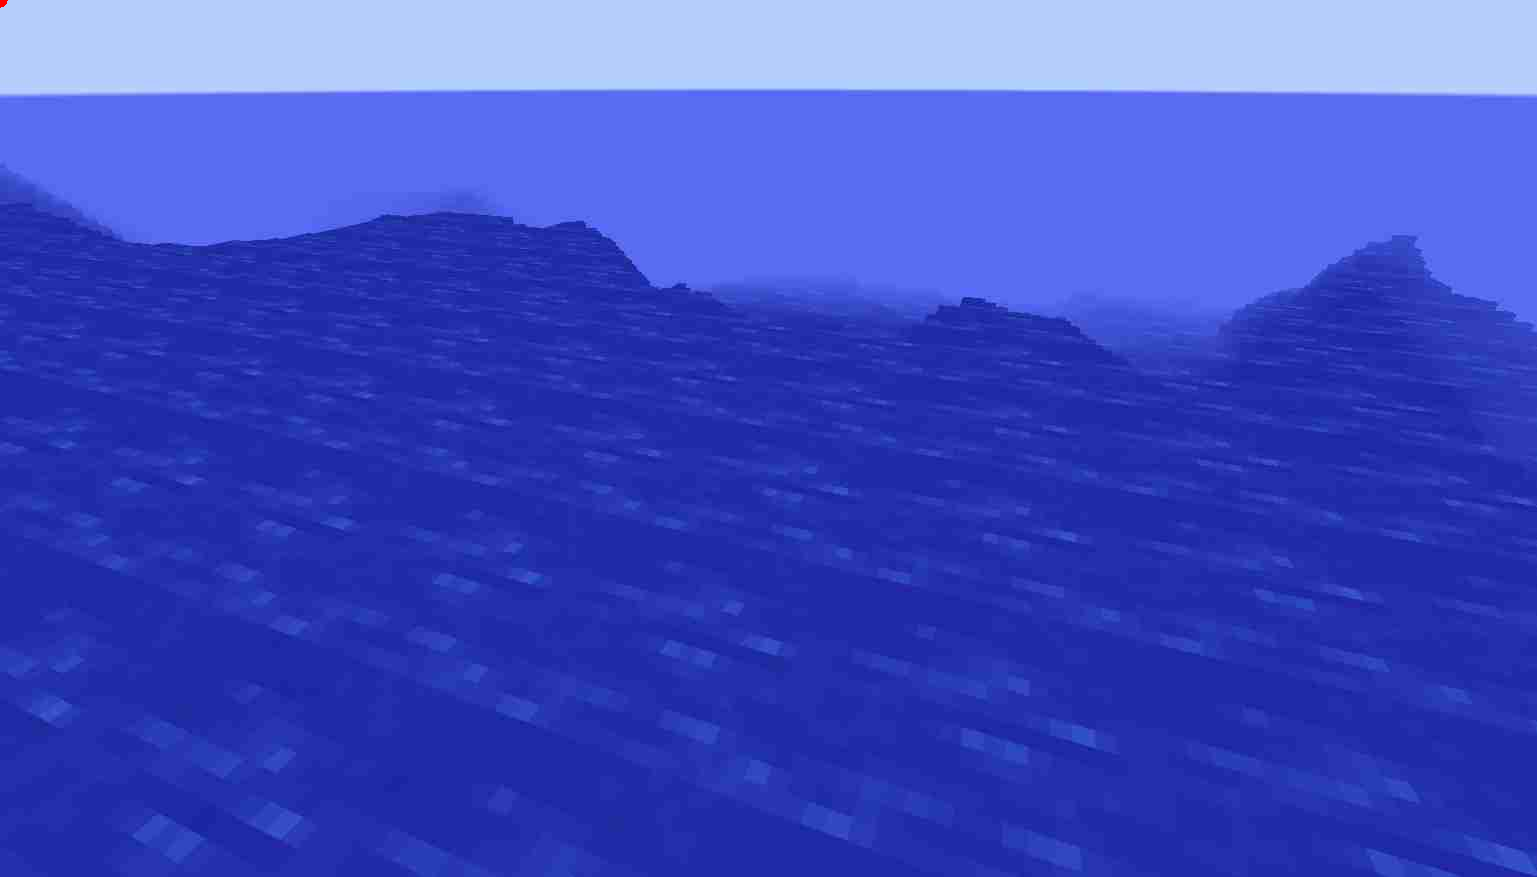

File name is  y-160_p15_t15360.jpg
index4


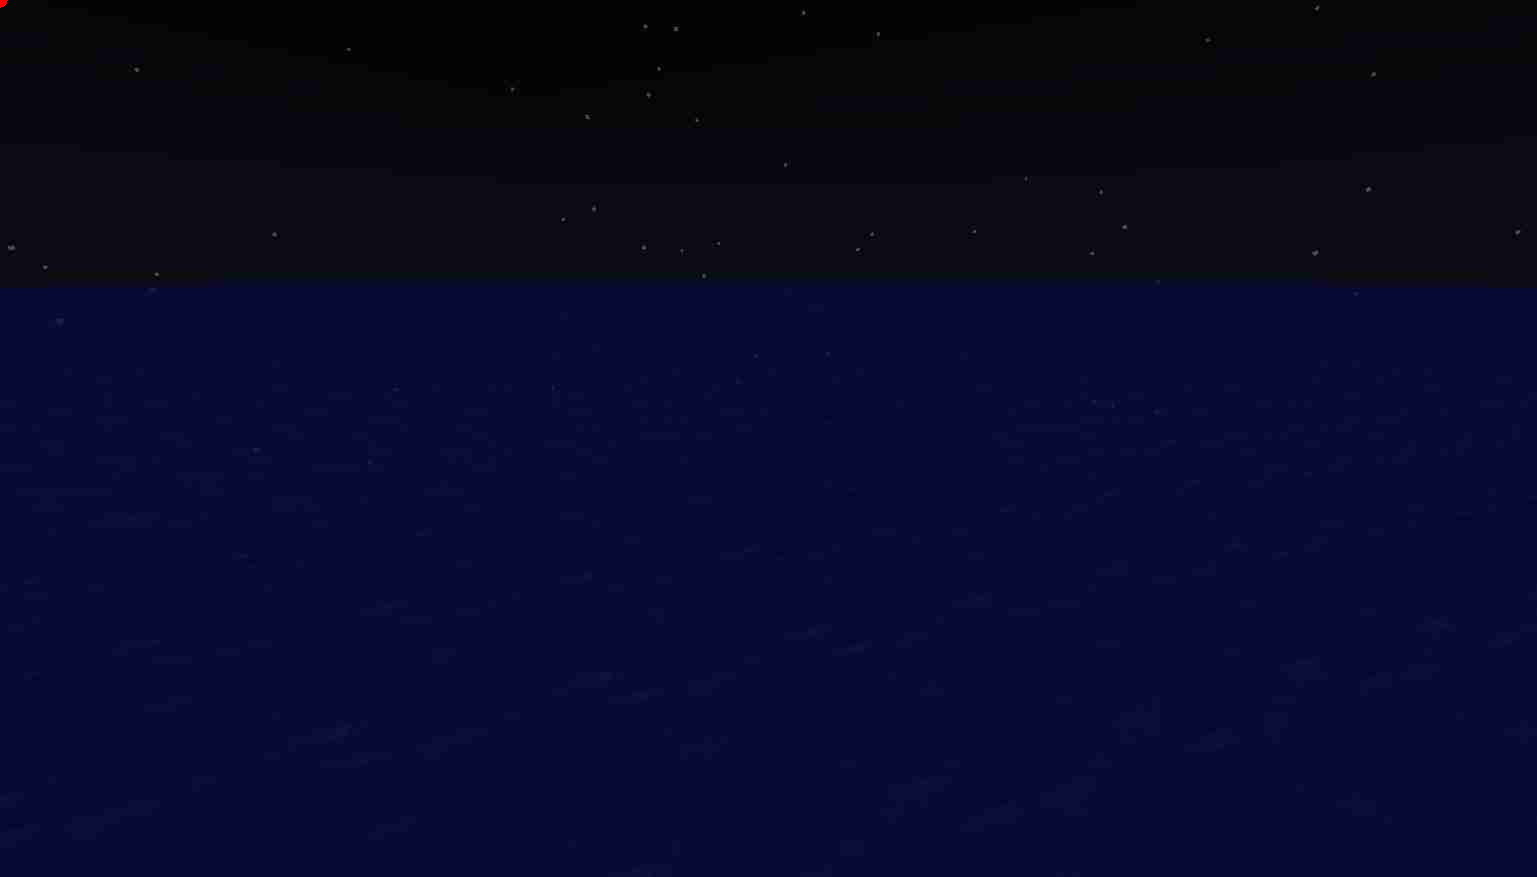

File name is  y120_p30_t5760.jpg
index5


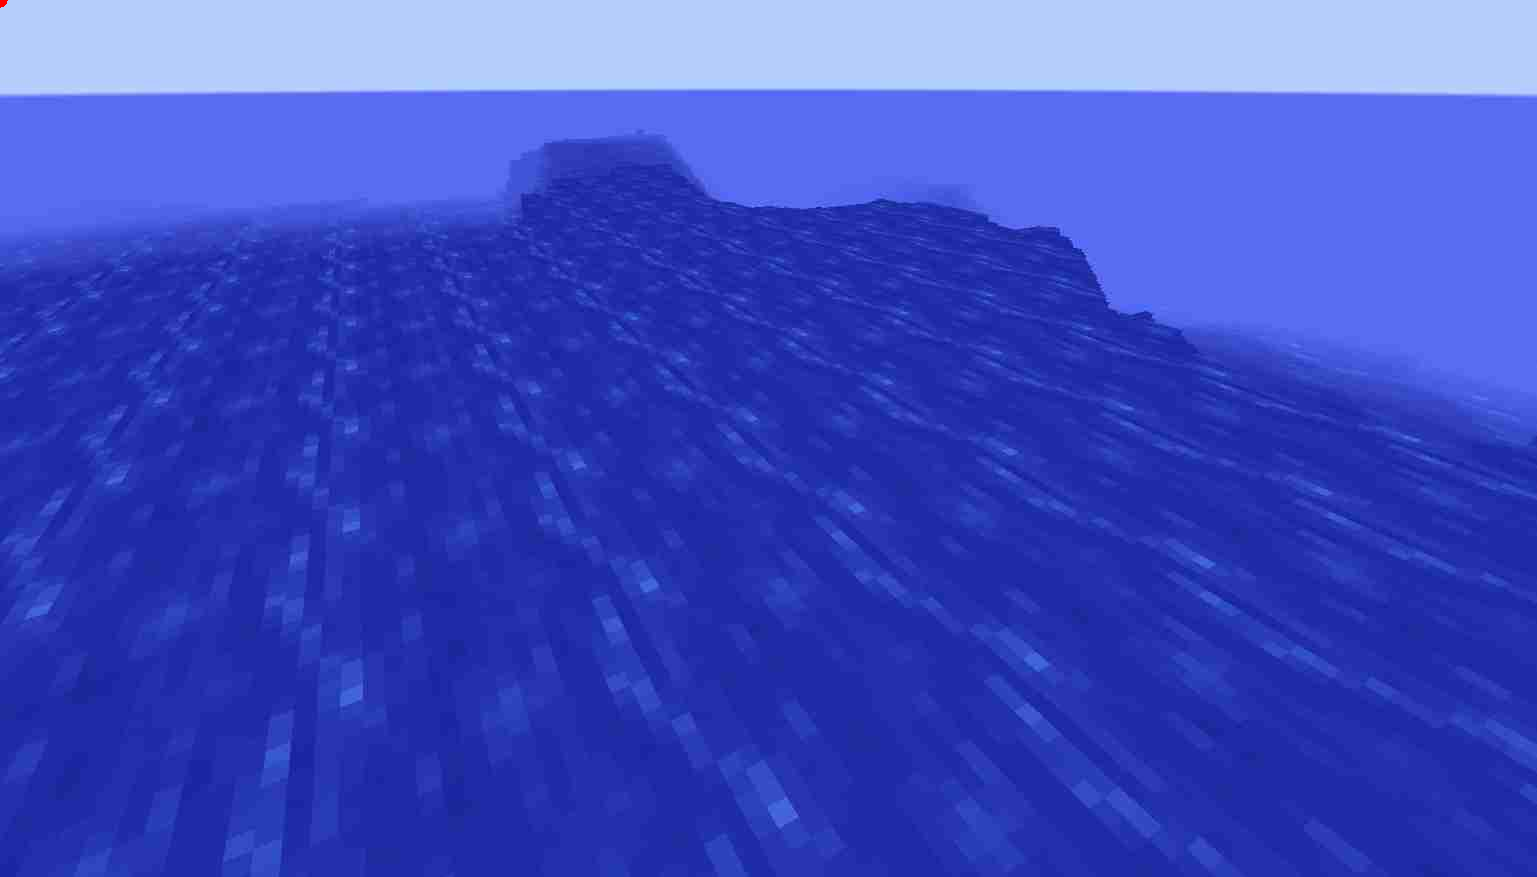

File name is  y-40_p-45_t7440.jpg
index7


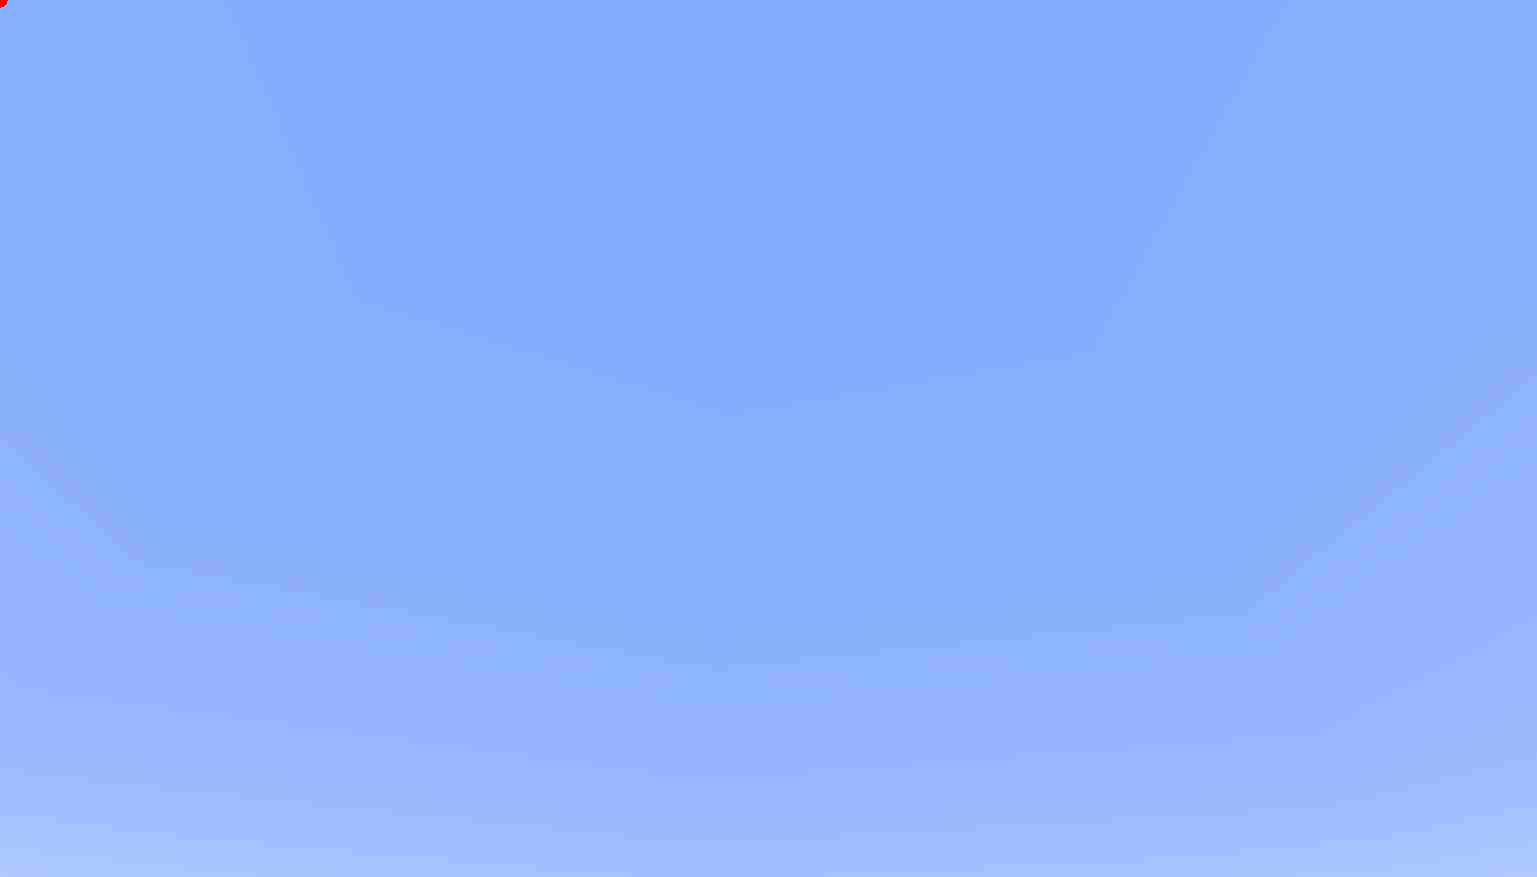

File name is  y-100_p0_t21120.jpg
index8


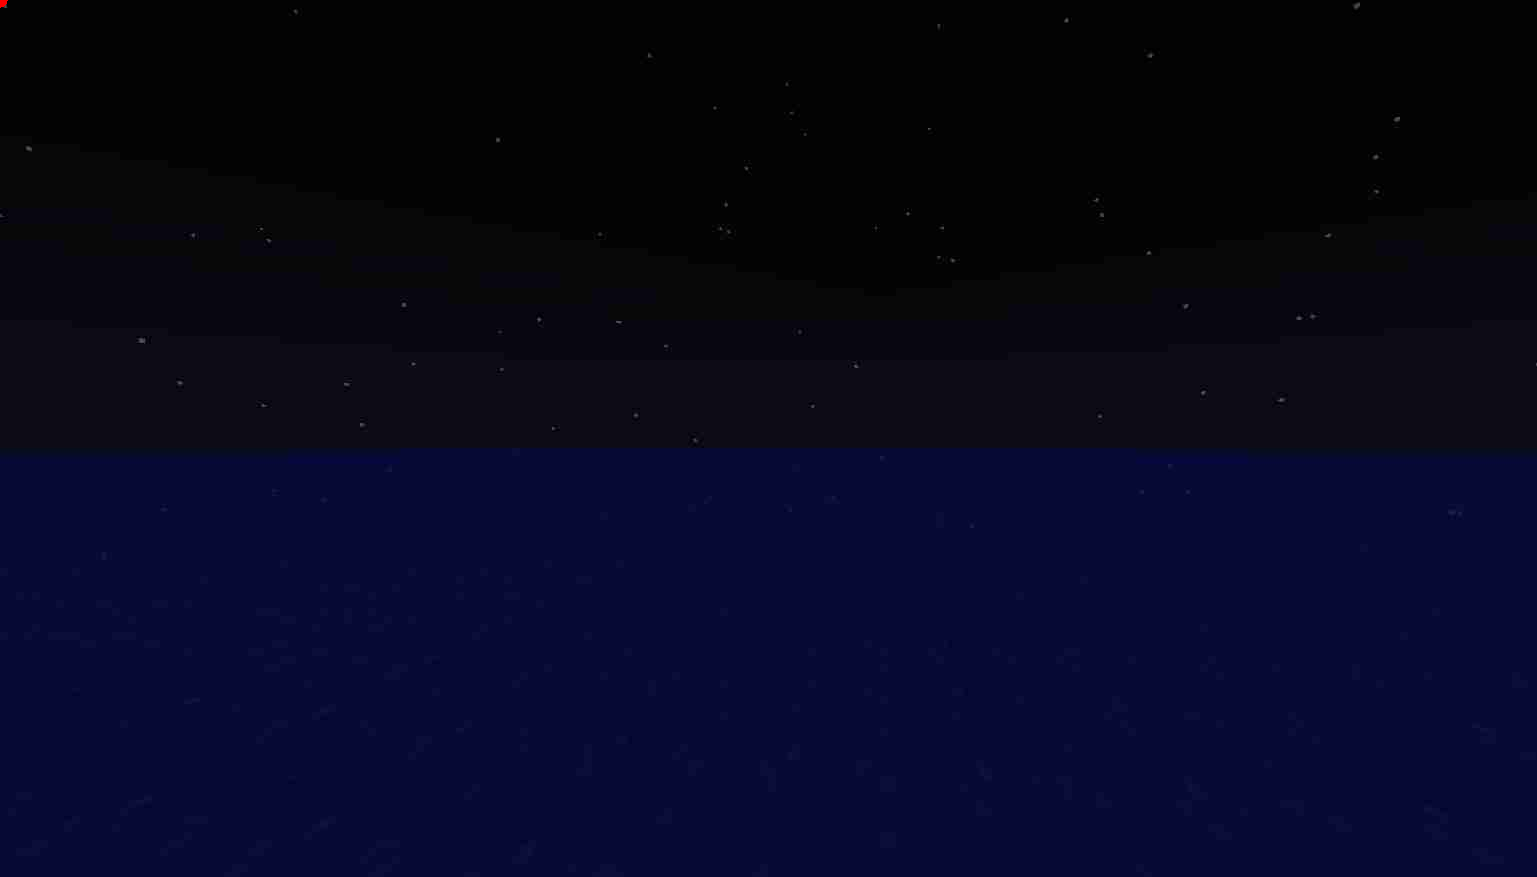

File name is  y40_p-30_t23760.jpg
index9


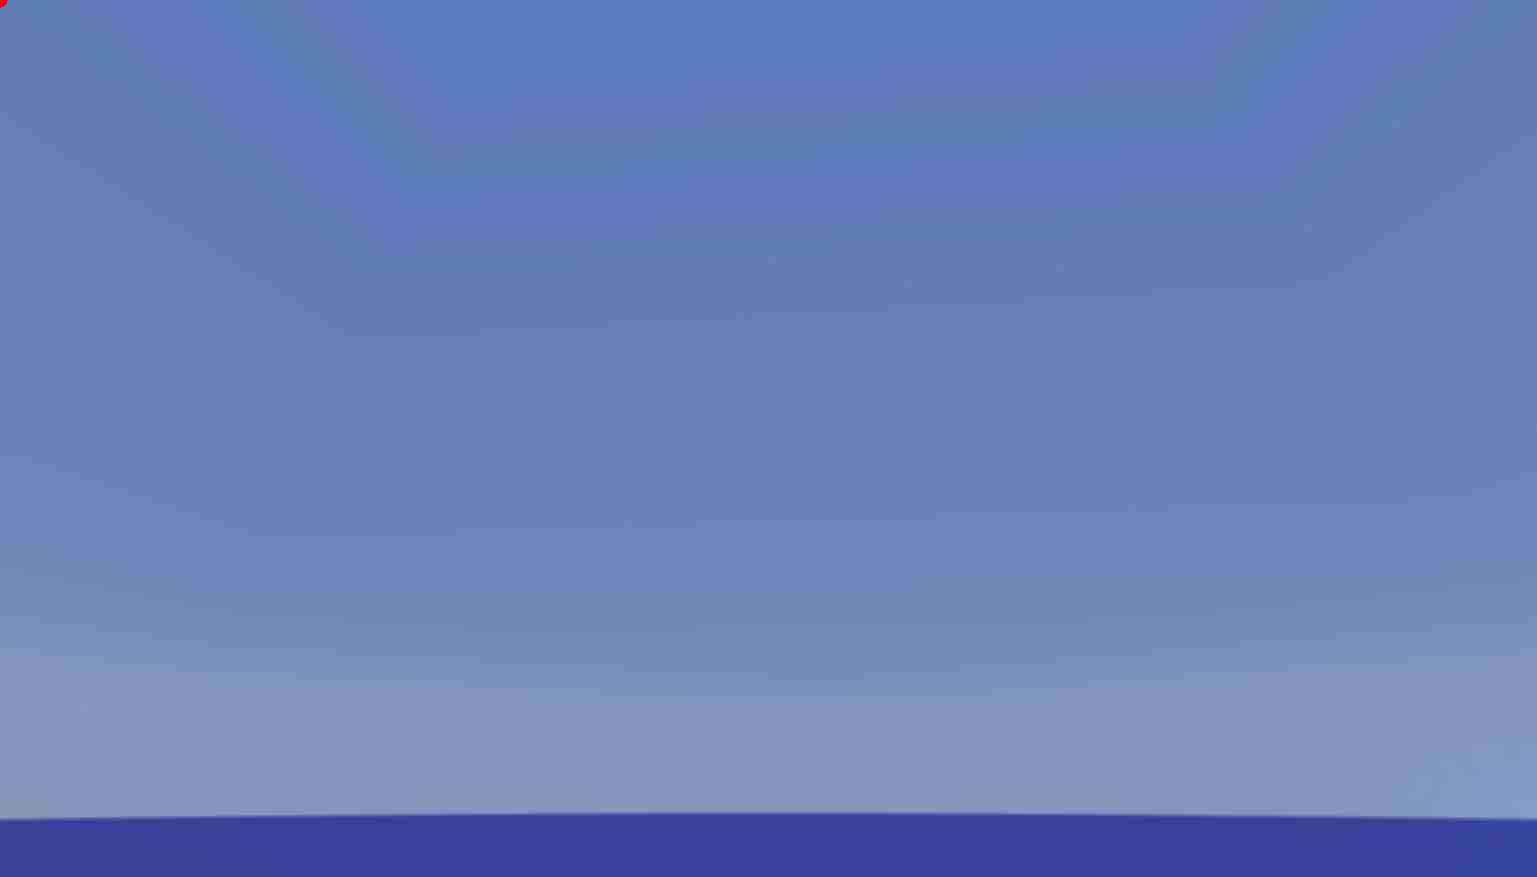

File name is  y-120_p0_t12480.jpg
index10


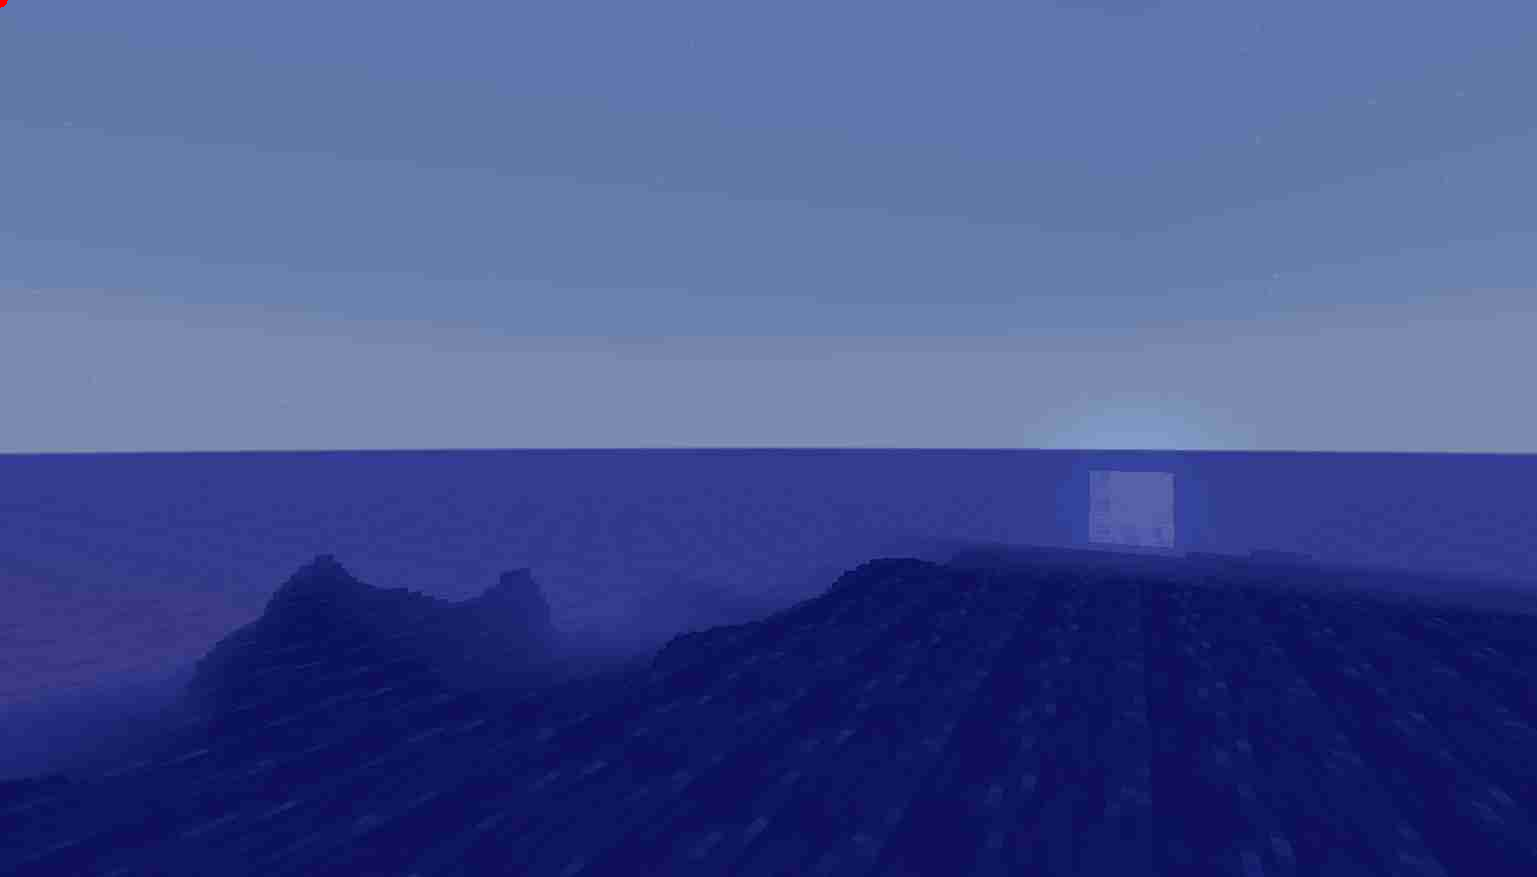

File name is  y-140_p-15_t4320.jpg
index11


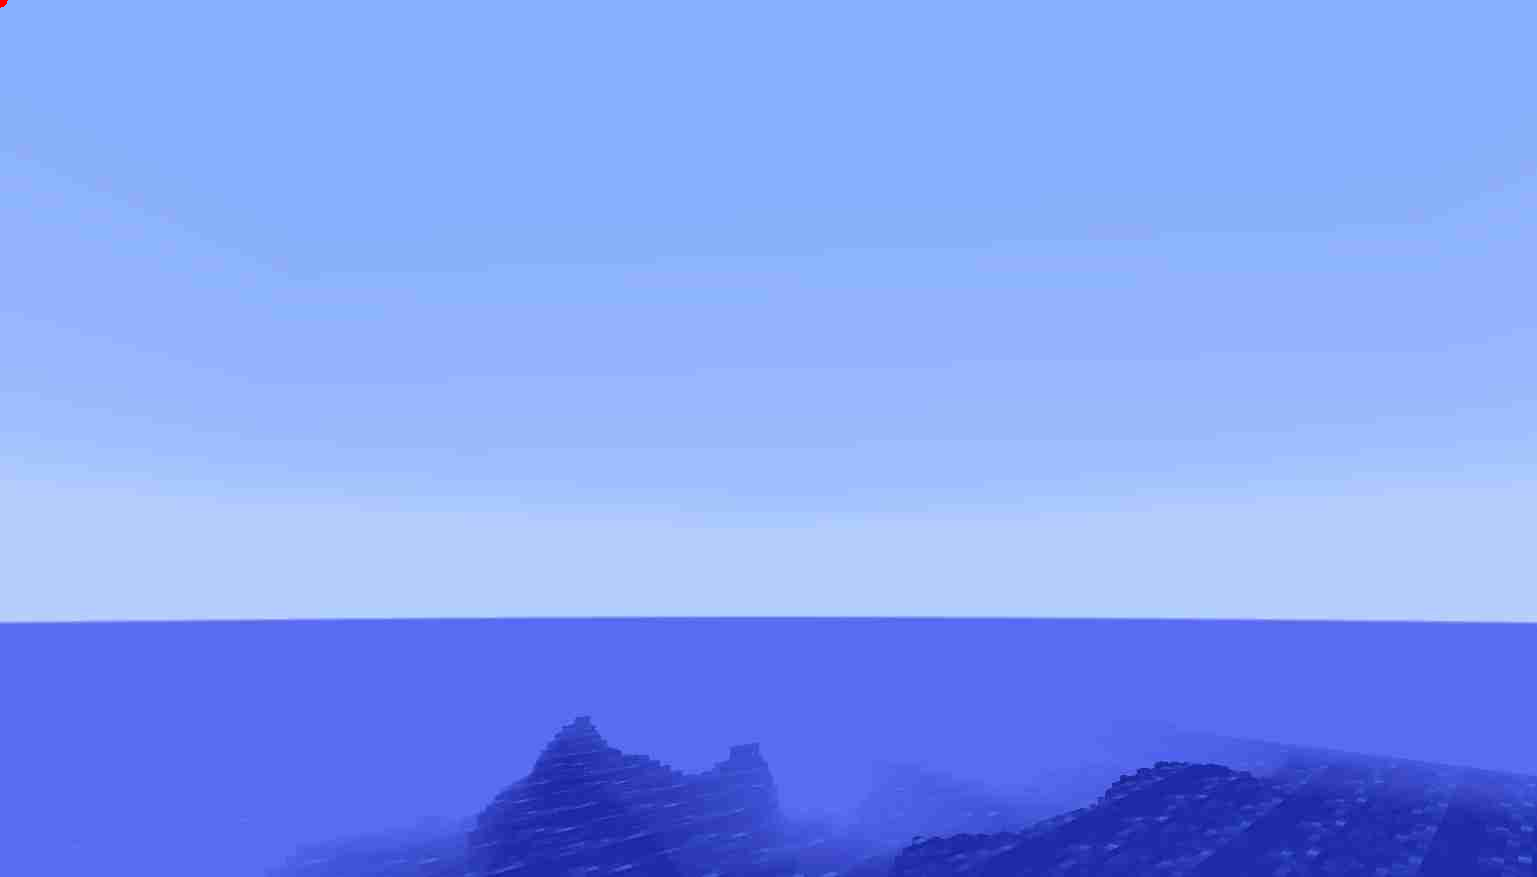

File name is  y100_p-30_t18000.jpg
index12


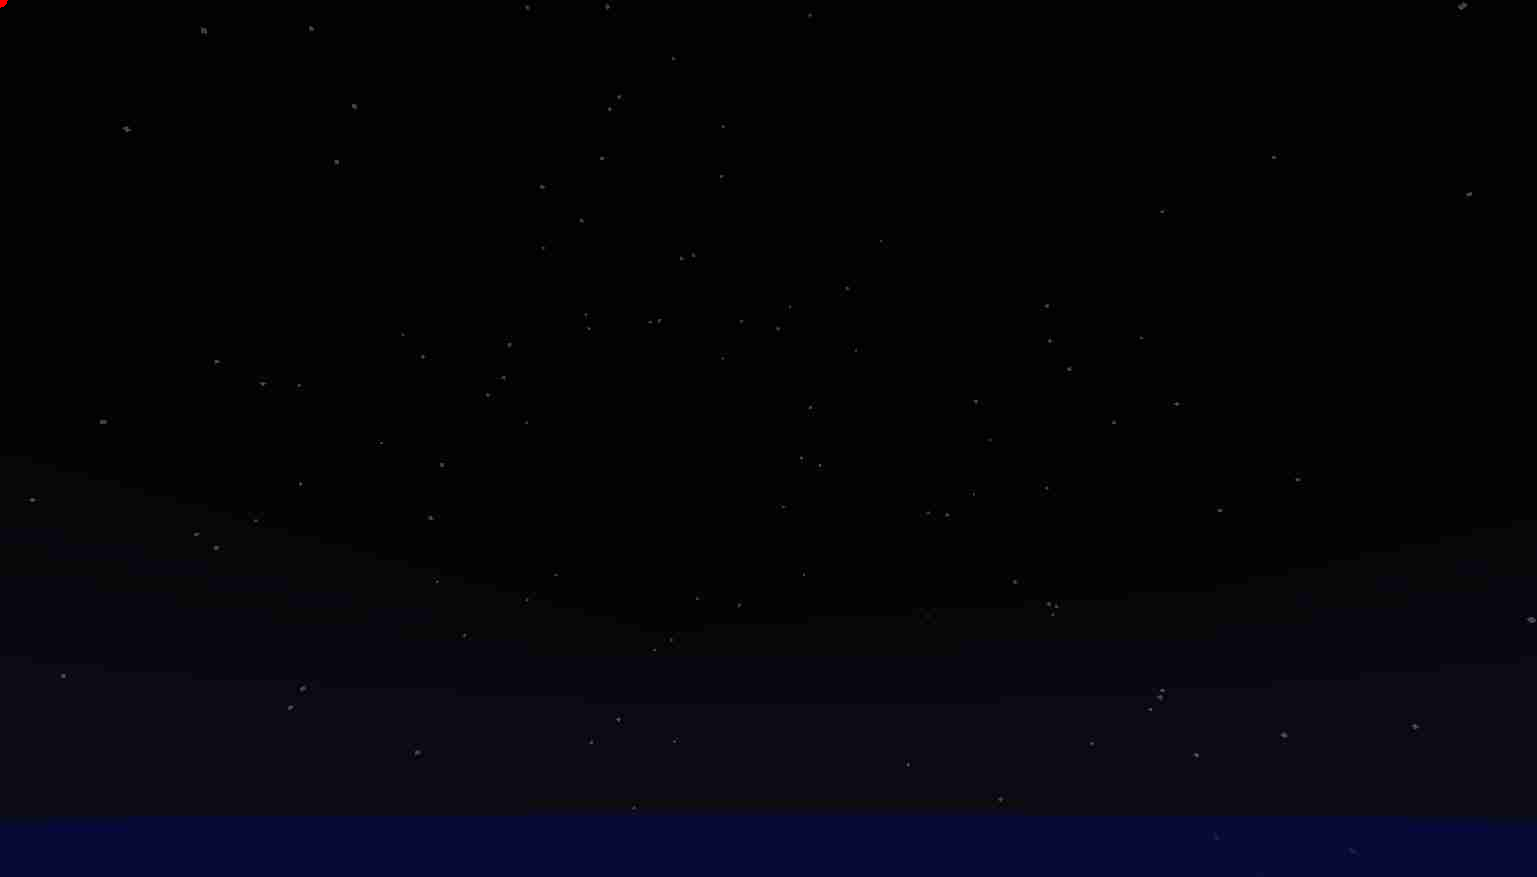

File name is  y140_p0_t2160.jpg
index13


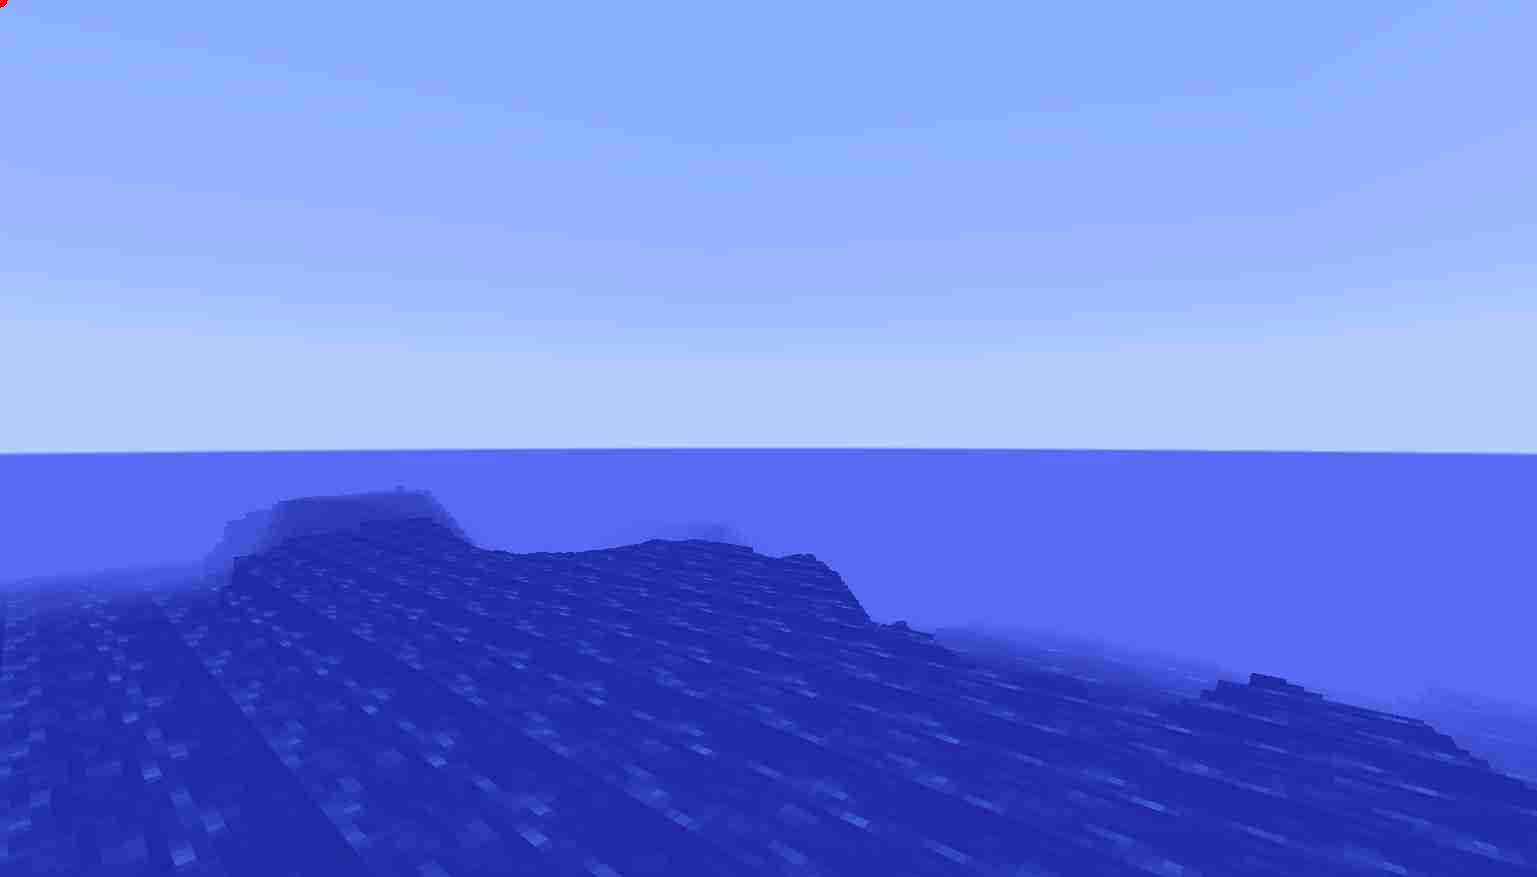

File name is  y-40_p-15_t11760.jpg
index14


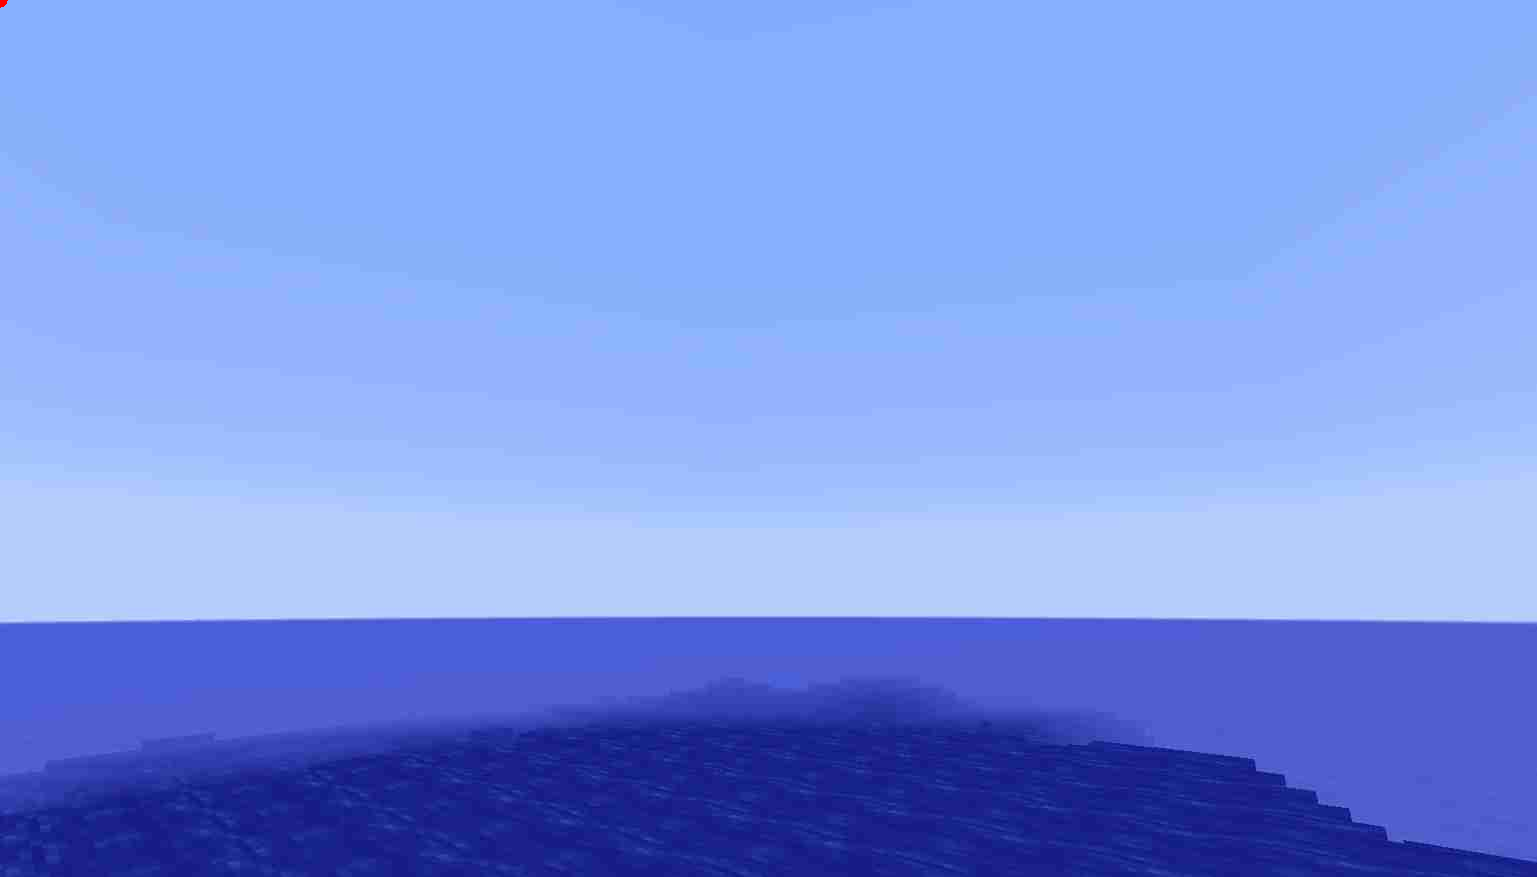

File name is  y-140_p-90_t18960.jpg
index15


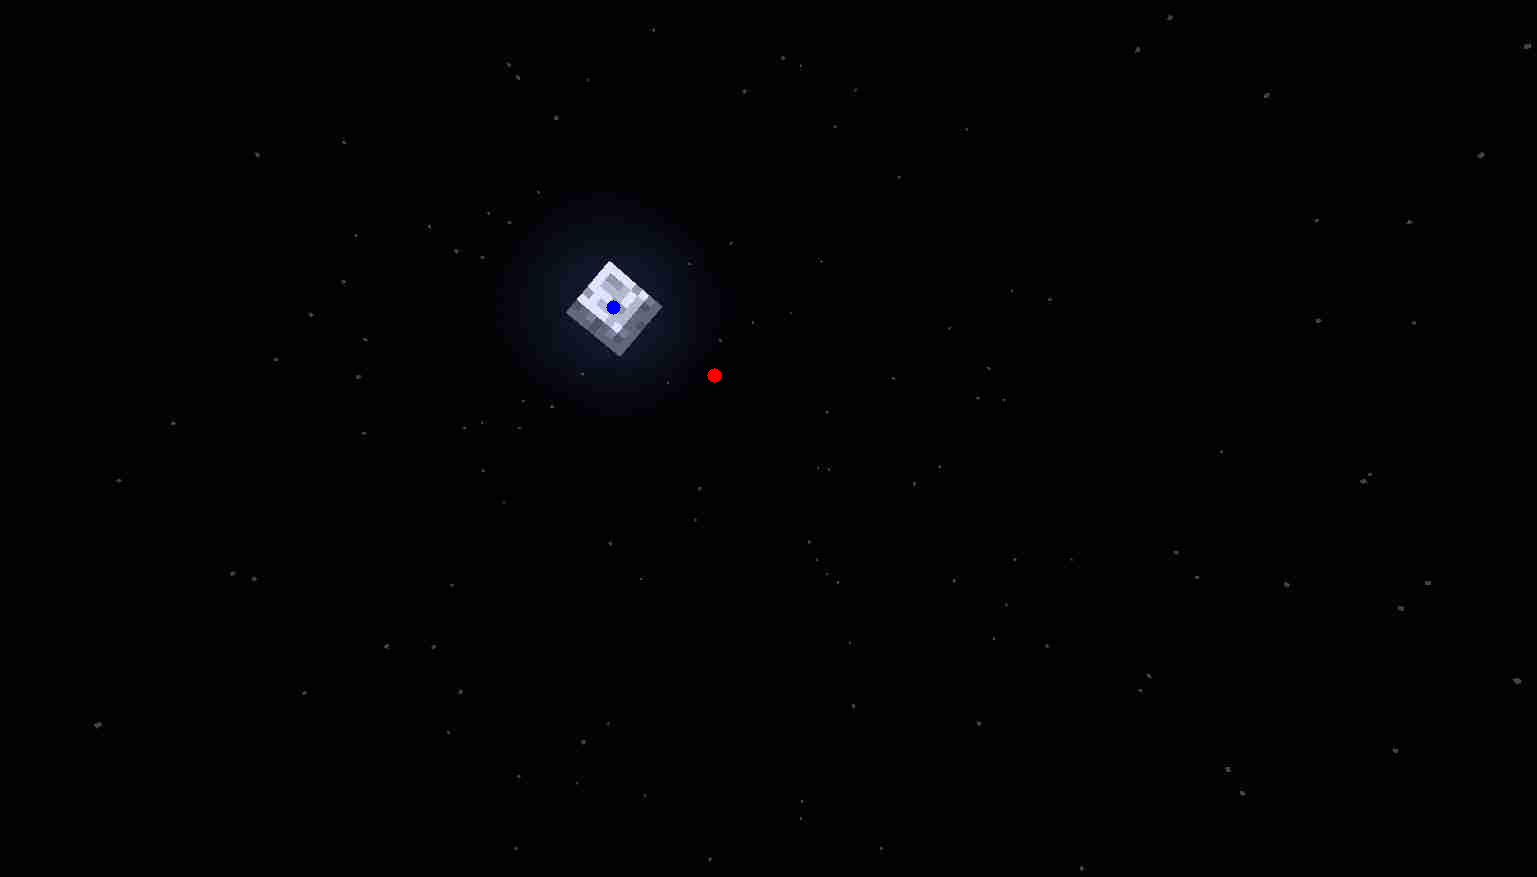

File name is  y60_p30_t17760.jpg
index16


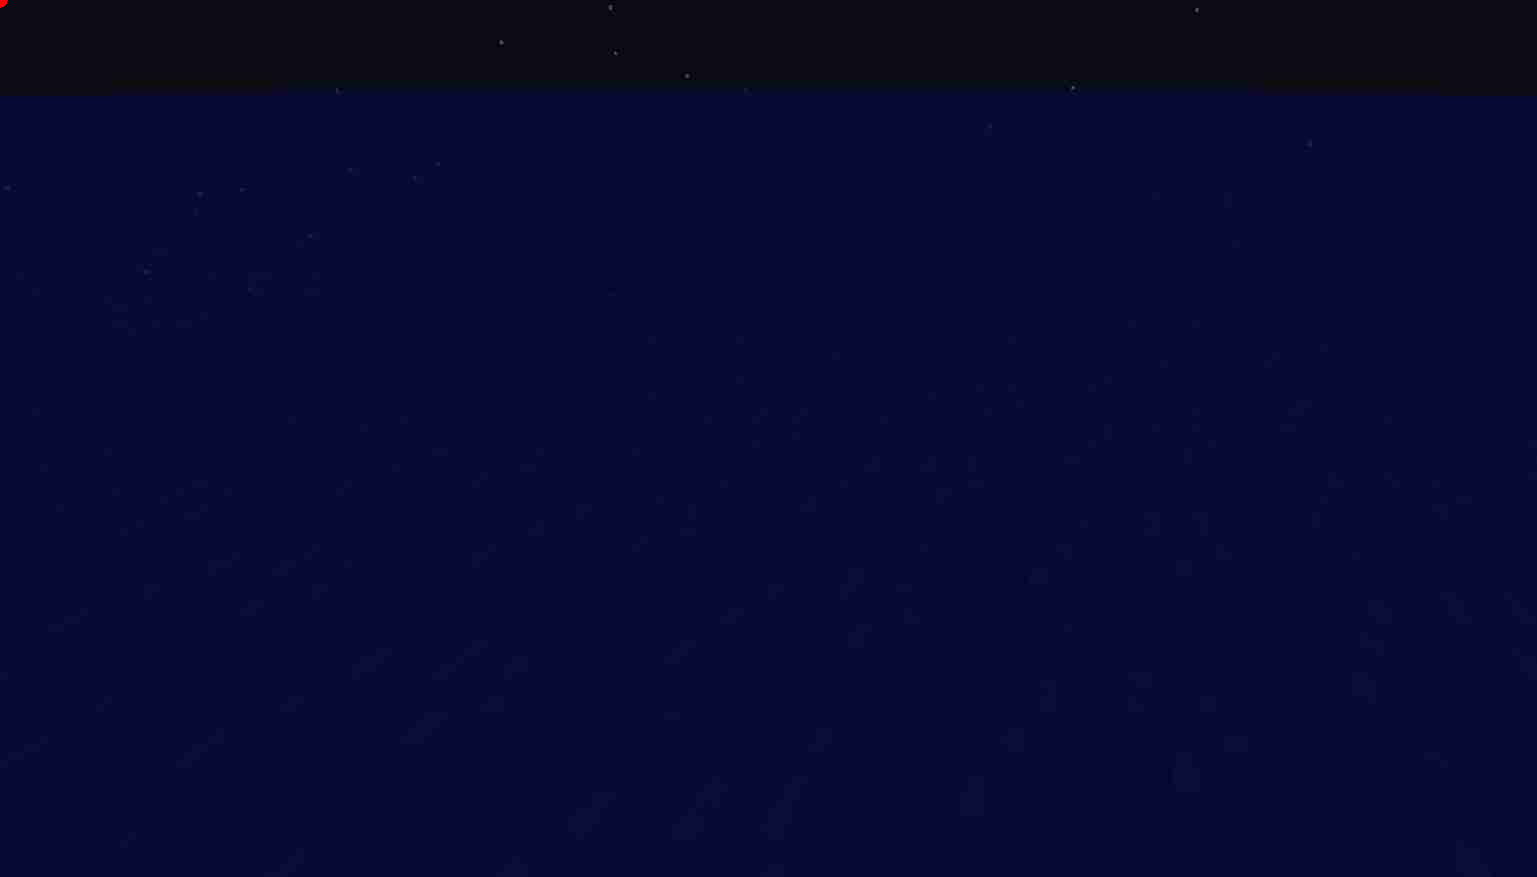

File name is  y-100_p-15_t11520.jpg
index17


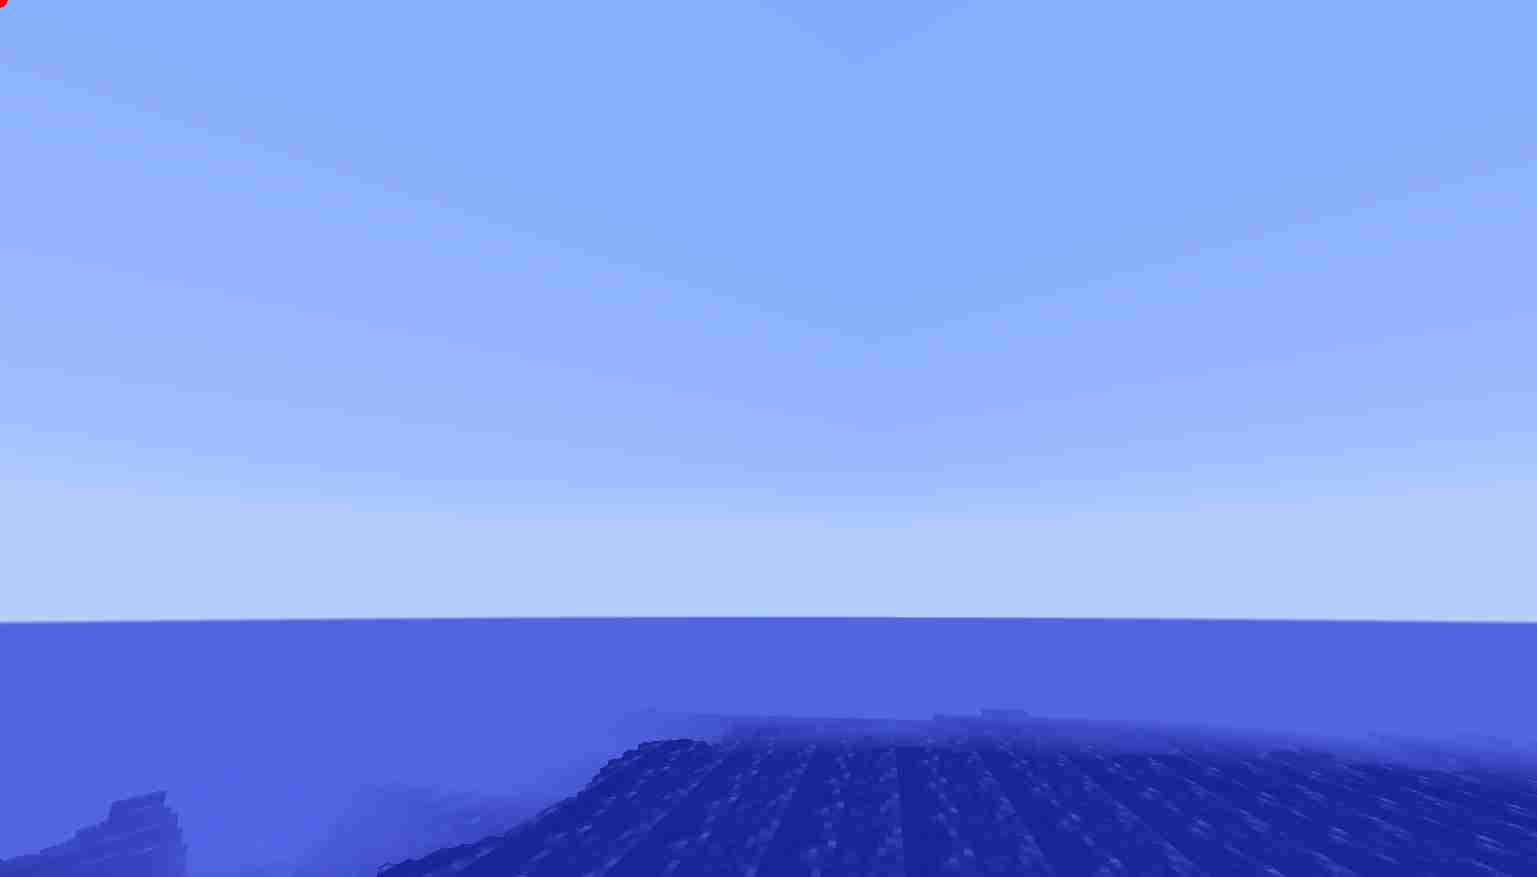

File name is  y-20_p-90_t5040.jpg
index18


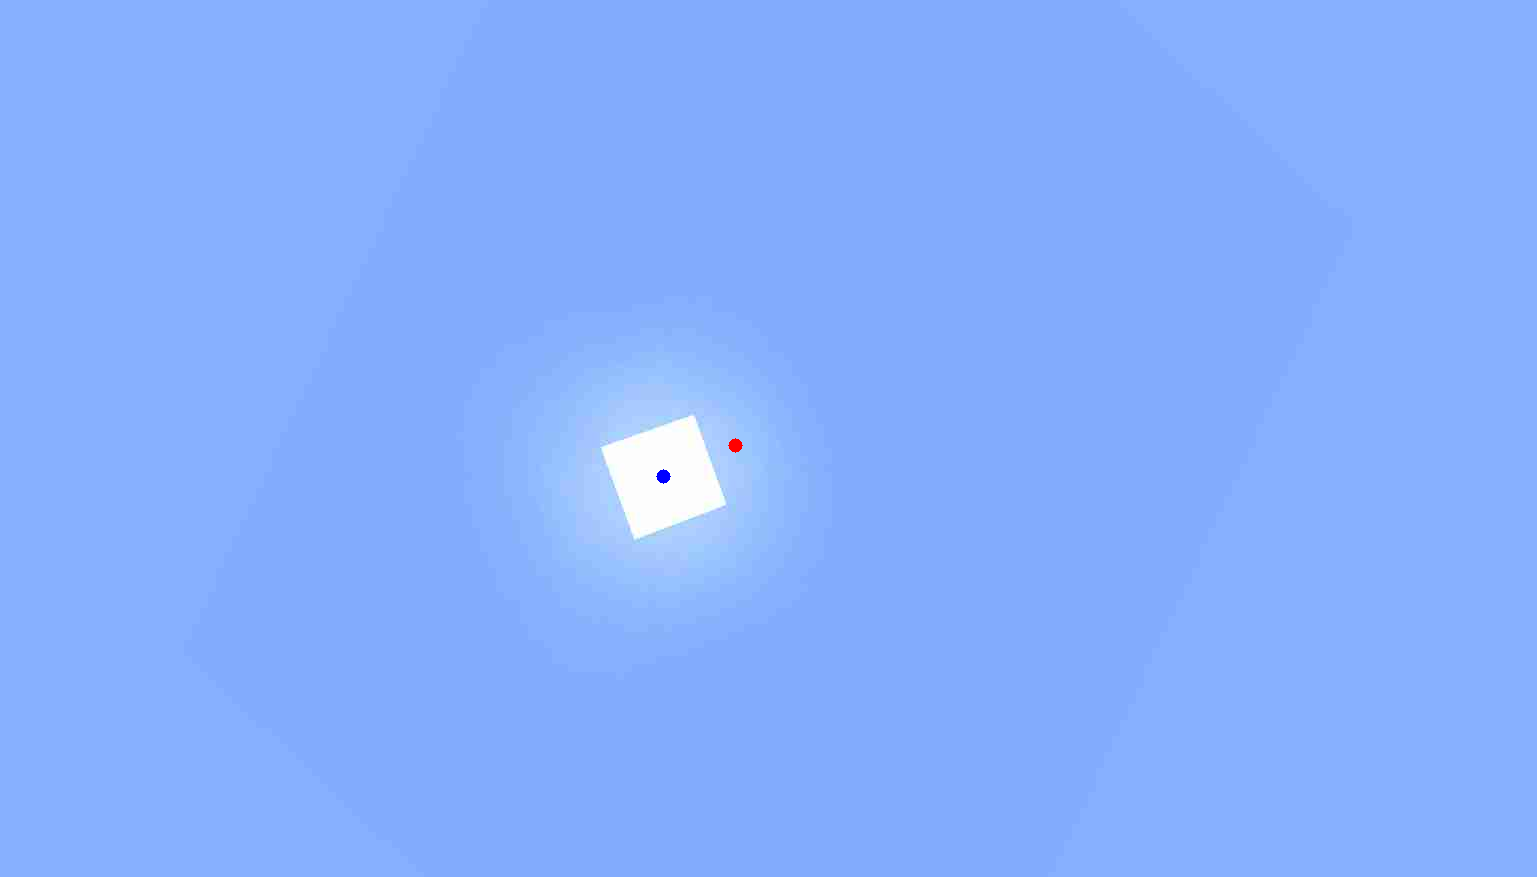

File name is  y80_p15_t0.jpg
index20


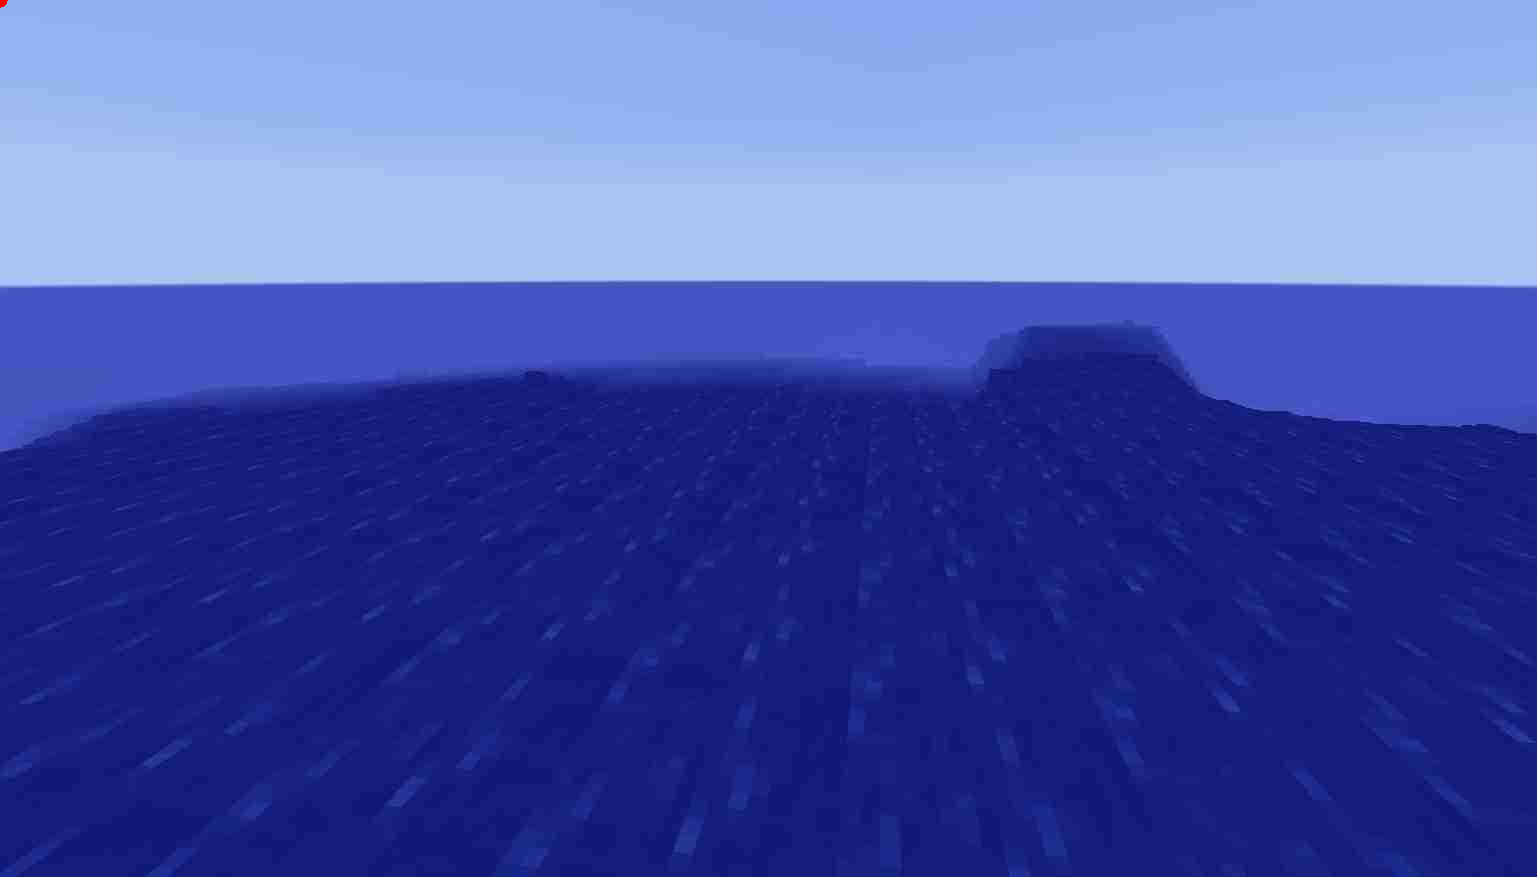

File name is  y-120_p-60_t19440.jpg
index21


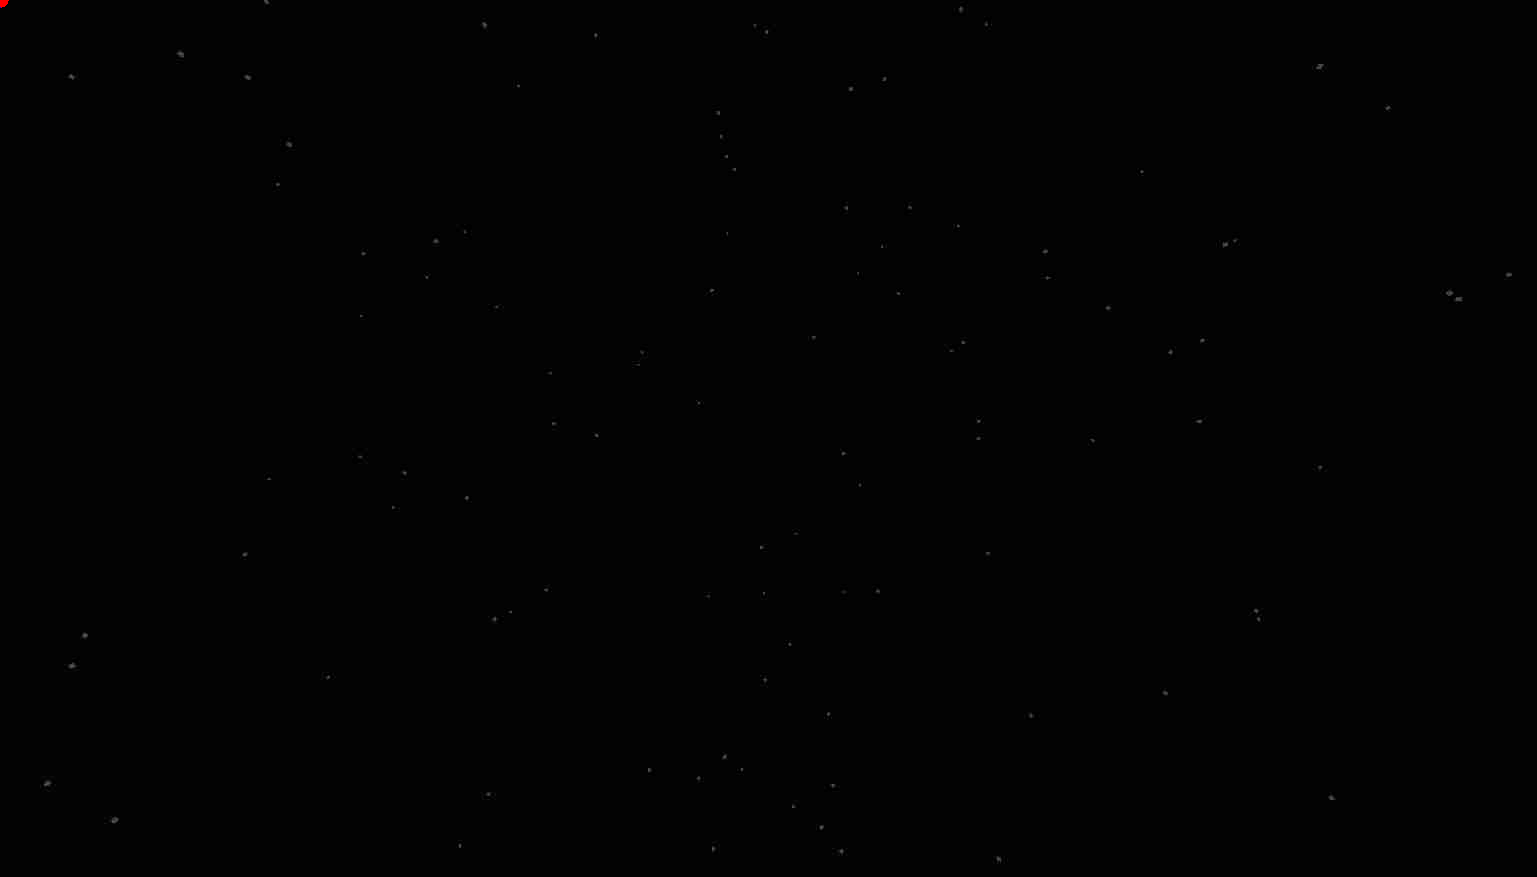

File name is  y-100_p30_t9840.jpg
index23


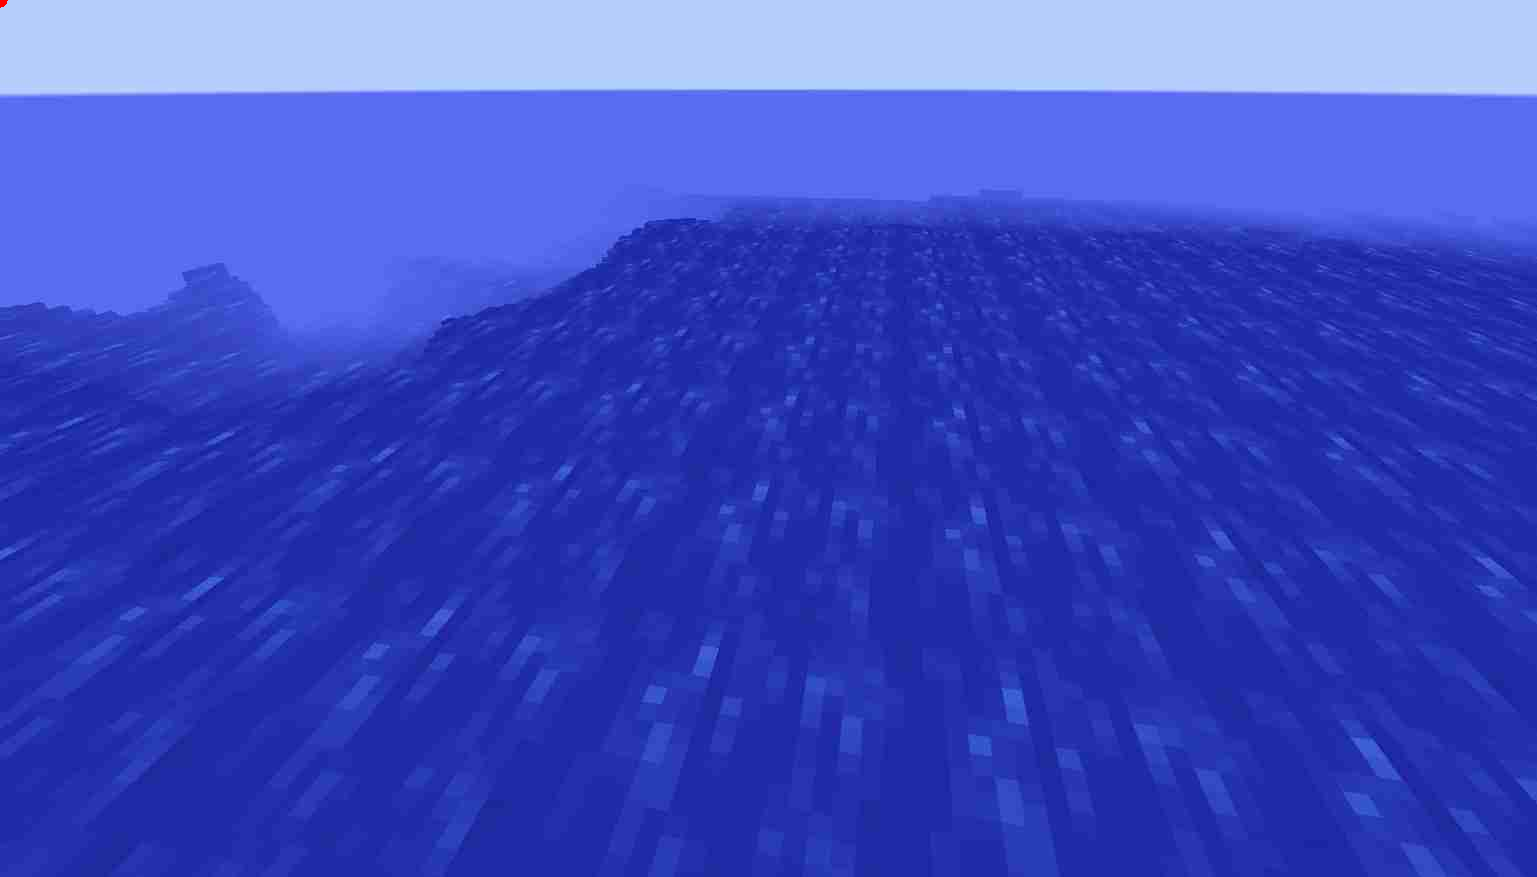

In [33]:
max_count = 20
count, ind = 0, 0
while count < max_count and ind < X_test.shape[0]:
  index = np.random.randint(0 , X_test.shape[0])
  point_x = X_test.iloc[index]
  point_y = y_test.iloc[index]
  point_pred = y_pred[index]
  fname = f"y{point_x['yaw']}_p{point_x['pitch']}_t{point_x['tick']}.jpg"
  img = cv2.imread(os.path.join(image_folder, fname))
  if img is None or  sum(point_y.to_numpy() - point_pred) > 70 :
  # if img is None or sum(point_y)  == 0:
    ind += 1
    continue
  print("File name is ", fname)
  print("index" + str(ind))
  is_sun = point_y["sun_X"] != 0
  cv2.circle(img, (point_y["sun_X"] if is_sun else point_y["moon_X"], point_y["sun_Y"] 
                   if is_sun else point_y["moon_Y"]), 7, (255, 0, 0), -1)
  cv2.circle(img, (int(y_pred[index][0]) if is_sun else int(y_pred[index][2]), int(y_pred[index][1]) 
  if is_sun else int(y_pred[index][3])), 7, (0, 0, 255), -1)
  cv2_imshow(np.uint8(img))
  count += 1
  ind += 1
# Get image folder and num images

A three dimensional visualization of the centroids of the celestial objects vs their squared error is plotted to determine if there are any patterns in the regions of high error. We observe that the model breaks down at the edges of the image. Further work would improve this weakness. Note the high error value on some of the points that are likely greatly driving up our MSE.

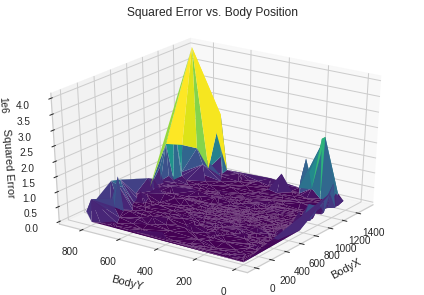

In [34]:
ax = plt.gca(projection='3d')
plt.tight_layout()
x, y, z = [], [], []
for i in range(y_test.shape[0]):
  point_y = y_test.iloc[i]
  point_pred = y_pred[i]
  is_sun = point_y["sun_X"] != 0
  if is_sun:
    x.append(point_y["sun_X"])
    y.append(point_y["sun_Y"])
  else:
    x.append(point_y["moon_X"])
    y.append(point_y["moon_Y"])
  z.append(sum(point_y - point_pred) ** 2)

ax.view_init(30, 215)
ax.set_xlabel("BodyX")
ax.xaxis.labelpad = 10
ax.set_ylabel("BodyY")
ax.yaxis.labelpad = 10
ax.set_zlabel("Squared Error")
ax.set_title("Squared Error vs. Body Position")
surf = ax.plot_trisurf(np.array(x), np.array(y), np.array(z), cmap='viridis', edgecolor='none')